# Indian Pines 特征选择
***
- 使用 softmax regression 作为分类器
- 使用lasso作为正则项

In [1]:
from scipy.io import loadmat#读取.mat
import spectral#可视化高光谱数据
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler#数据标准化
from sklearn.model_selection import StratifiedKFold#分层交叉验证


import glmnet_python#计算带有凸惩罚的广义线性模型
from glmnet import glmnet
import scipy
import matplotlib.pyplot as plt

## 用于储存高光谱数据的结构体
***
- 可以对高光谱数据可视化

In [2]:
class hyperspectral_data:
    """
        用于存储高光谱数据的结构体，初始化传入img_path和groudtruth_path
    """
    def __init__(self,img_path,groudtruth_path):
        """
            初始化函数
        """
        self.img_path = img_path
        self.groudtruth_path = groudtruth_path
        
        self.data = loadmat(self.img_path)['indian_pines_corrected']#图像数据
        self.label = loadmat(self.groudtruth_path)['indian_pines_gt']#标签数据
    def print_img(self):
        """
            显示高光谱数据
        """
        view = spectral.imshow(self.data,(30,20,10),classes=self.label)
        view.set_display_mode('overlay')
        view.class_alpha = 0.5
    def print_gt(self):
        """
            显示标签分布的图像
        """
        view_ = spectral.imshow(self.label)

## 加载印第安纳松树数据集

In [3]:
img_path = '/home/ysq/桌面/高光谱数据特征选择/data/Indian_pines_corrected.mat'#数据路径
gt_path = '/home/ysq/桌面/高光谱数据特征选择/data/Indian_pines_gt.mat'#标签路径
indian_pines = hyperspectral_data(img_path,gt_path)

### 对数据可视化

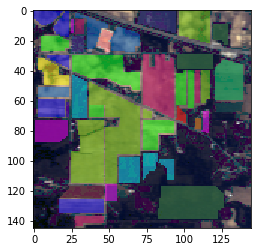

In [4]:
#图像+分类
indian_pines.print_img()

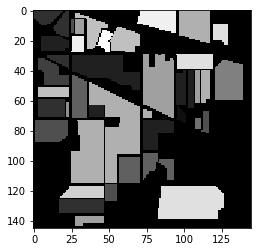

In [5]:
#分类图像
indian_pines.print_gt()

### 查看数据维数
***
- 数据共200个波段，每个波段可看做一个属性
- 该数据集共有16类

In [6]:
print(indian_pines.data.shape,'\n',indian_pines.label.shape)

(145, 145, 200) 
 (145, 145)


In [7]:
indian_pines.label[0]

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  0,  3,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint8)

In [8]:
indian_pines.data[1].shape

(145, 200)

## 数据预处理
***
### 构建数据预处理结构体
- 对高光谱数据进行reshape操作，将三维数据矩阵拉成二维矩阵，将二维标签矩阵拉成一维列向量，便于后续操作
- 对传入数据进行标准化操作
- 删除没有标记的数据及其标签

In [9]:
class preprocessing:
    """
        运行LASSO算法前，对传入的数据进行预处理
    """
    def __init__(self,data,label):
        """
            初始化函数
            data为传入的数据，label为标签
            w为参数向量
        """
        self.data = data
        self.label = label
        self.w = np.ones((self.data.shape[2],1))
    def reshape_data(self):
        """
            将三维数据矩阵拉成二维，将二维标签矩阵拉成一维列向量，便于后续处理
        """
        self.data = self.data.reshape([145*145,200]) #拉成二维矩阵
        self.label = self.label.reshape([-1,1]) #拉成列向量
        #print(self.data.shape,self.label.shape)
        #问题变成了具有21025个有标签数据的学习任务
    
    def standardize(self):
        """
            对数据进行标准化
        """
        scaler = StandardScaler()#标准化处理函数
        self.data = scaler.fit_transform(self.data)

    def delet_unlabel_data(self):
        """
                删除未标注数据
        """
        merge = np.concatenate((self.data,self.label),axis=1)
        df = pd.DataFrame(merge) #ndarray-->dataframe
        del_index = df[df[200]==0].index#获取未标注数据的标号
        df_with_label = df.drop(del_index)#去除未标注数据
        
        ###### 查看是否已经去除完毕
        label = df_with_label[200].values#获取标签
        list_ = np.unique(label)
        if 0 not in list_:
            """
                 原始数据中标注为0的是未分类数据
            """
            print('已经去除了未标记数据')
        
        self.x = df_with_label.values[:,:200] #有标签的数据
        self.y = df_with_label.values[:,-1].reshape(-1,1) #数据对应的标签
        

In [10]:
model = preprocessing(indian_pines.data,indian_pines.label)
model.reshape_data()
model.standardize()
np.unique(model.label)#类别为0的表示数据中未标注的部分
model.delet_unlabel_data()

已经去除了未标记数据


/home/ysq/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
x = np.float64(model.x)
y = np.float64(model.y)

## 使用glmnet拟合数据

In [12]:
# fit = cvglmnet(x=x.copy(),y=y.copy(),alpha = 1,family='multinomial',mtype='grouped'
#                ,standardize=False,maxit = 1000000)

In [13]:
fit = glmnet(x=x.copy(),y=y.copy(),alpha = 1,family='multinomial',
             standardize=False,mtype='grouped')

from glmnet.py print mtype grouped <class 'str'>
from glmnet.py print indxtf [False, True] <class 'list'>
from glmnet.py print indm: [1] <class 'list'>
from glmnet.py print kopt: 2 <class 'int'>
from start of lognet.py print kopt: 2
Check results for accuracy. Partial or no results returned.
from longnet print kopt: 2
运行完毕！


In [14]:
fit

{'a0': array([[-1.95745064, -1.95694616, -1.95566129, -1.95319831, -1.94933078,
         -1.94361303, -1.93575355, -1.92511993, -1.91187839, -1.89546852,
         -1.87613578, -1.85333629, -1.82740922, -1.79876852, -1.77001365,
         -1.73809504, -1.70274886, -1.6632464 , -1.62023613, -1.57436075,
         -1.52537115, -1.47451383, -1.41990446, -1.36245696, -1.30258202,
         -1.24180242, -1.1801025 ],
        [ 1.47793811,  1.44675385,  1.41629773,  1.38601576,  1.35525687,
          1.3234163 ,  1.29155504,  1.2652396 ,  1.23753332,  1.20770818,
          1.17637752,  1.14484205,  1.10686657,  1.06327551,  1.01707321,
          0.97578639,  0.93921414,  0.90377746,  0.87108308,  0.8401968 ,
          0.80961417,  0.78410988,  0.75821373,  0.72110922,  0.67425714,
          0.62013576,  0.56279308],
        [ 0.93533367,  0.92234552,  0.91156419,  0.90182635,  0.89256445,
          0.88336462,  0.87413152,  0.8654647 ,  0.85578407,  0.84460018,
          0.83142132,  0.81534801,

## 惩罚系数lambda有100个，历史数据存在beta中

In [15]:
beta_all = np.array(fit['beta'])#获取所有lambda对应的beta矩阵
print('惩罚系数个数',fit['lambdau'].shape)
print('beta维度',beta_all.shape)
print('偏置维度',fit['a0'].shape)
print(fit)

惩罚系数个数 (27,)
beta维度 (16, 200, 27)
偏置维度 (16, 27)
{'a0': array([[-1.95745064, -1.95694616, -1.95566129, -1.95319831, -1.94933078,
        -1.94361303, -1.93575355, -1.92511993, -1.91187839, -1.89546852,
        -1.87613578, -1.85333629, -1.82740922, -1.79876852, -1.77001365,
        -1.73809504, -1.70274886, -1.6632464 , -1.62023613, -1.57436075,
        -1.52537115, -1.47451383, -1.41990446, -1.36245696, -1.30258202,
        -1.24180242, -1.1801025 ],
       [ 1.47793811,  1.44675385,  1.41629773,  1.38601576,  1.35525687,
         1.3234163 ,  1.29155504,  1.2652396 ,  1.23753332,  1.20770818,
         1.17637752,  1.14484205,  1.10686657,  1.06327551,  1.01707321,
         0.97578639,  0.93921414,  0.90377746,  0.87108308,  0.8401968 ,
         0.80961417,  0.78410988,  0.75821373,  0.72110922,  0.67425714,
         0.62013576,  0.56279308],
       [ 0.93533367,  0.92234552,  0.91156419,  0.90182635,  0.89256445,
         0.88336462,  0.87413152,  0.8654647 ,  0.85578407,  0.84460018,

In [16]:
beta_all.shape #16是数据类别数，200是波段数，100是算法运行时惩罚系数lambda的个数
b0 = fit['a0']
fit['lambdau'].shape[0]
# fit['label'].shape
# fit['beta'][0].shape

27

## 进行波段选择

In [17]:
def BandSelection(glmnet_fit_dic):
    """
        进行波段选择
        --------------------------------------
        参数:
        glmnet_fit_dic : 经过glmnet中的 使用multinomial regression(多类逻辑回归)
        对该多分类问题建模，并使用含惩罚项的对数似然函数作为代价函数，优化该函数求解系数矩阵B
        后获得的字典
        
        glmnet_fit_dic为一个字典，我们试图获取不同惩罚系数lambda下对应的系数矩阵（稀疏）B
        在程序中，B为16*200*100的三维数组，先遍历100个lambda对应的二维矩阵B',B'∈ R(16*200)
        B'的每一行对应的是一个类别下的200个波段的系数，我们对B'进行行遍历，从中挑选非0值对应的列下标，
        该列下标若非零则说明在图像分类时，此波段信息起到了作用，若为0则说明该波段信息是对分类任务无效的
        
        返回值:
        一个列表bandset,其中的元素是不同惩罚系数对应的应选择的波段下标组成的集合
        -------------------------------------------------------
        此方法参考了
        D. Yang and W. Bao. Group lasso-based band selection for hyperspectral image classification. 
        IEEE Geoscience and Remote Sensing Letters, 14(12):2438¨C2442, Dec 2017. 7.
        
    """
    #获取每个lambda对应的波段
    #######################
    #glmnet在运行时使用了坐标下降优化算法，且维护了一个递减的惩罚系数
    #lambda向量，具体算法参考
    #Jerome Friedman,Trevor Hastie,Rob Tibshirani:Regularization Paths for Generalized Linear Models
    #via Coordinate Descent. 2010
    bandset = []#空列表，储存不同惩罚系数lambda对应的波段选择情况
    
    for i in range(glmnet_fit_dic['lambdau'].shape[0]):
        """
            遍历每个lambda下的数据，此处惩罚系数lambda共100个
        """
        u = []
        u = set(u)#列表转集合
        for j in range(glmnet_fit_dic['label'].shape[0]):
            """
                遍历每个类坐标 对于Indian Pines共16个
                (对B'进行行遍历)
            """
            co = glmnet_fit_dic['beta'][j]#该类坐标下的beta矩阵
            sel = [index for (index,value) in enumerate(co[:,i]) if value!=0] #i代表当前惩罚系数下标
            #在当前第i个lambda惩罚系数下，从所有16个列坐标下选取非零元素对应的波段序号（可选的有200个波段）
            u = set.union(u,set(sel))#集合求并集
        bandset.append(u)#bandset添加元素
    return bandset

In [18]:
band_selected = BandSelection(fit)
i = 1
for item in band_selected:
    if item == set():
        print(f'第{i}个惩罚系数选择出的波段标号集合为空集')#处理空集
    else:
        print(f'第{i}个惩罚系数选择出的波段标号集合为{item},共{len(item)}个波段')
    i += 1

第1个惩罚系数选择出的波段标号集合为空集
第2个惩罚系数选择出的波段标号集合为{148, 149},共2个波段
第3个惩罚系数选择出的波段标号集合为{148, 149},共2个波段
第4个惩罚系数选择出的波段标号集合为{148, 149},共2个波段
第5个惩罚系数选择出的波段标号集合为{148, 149},共2个波段
第6个惩罚系数选择出的波段标号集合为{148, 149},共2个波段
第7个惩罚系数选择出的波段标号集合为{148, 149, 74},共3个波段
第8个惩罚系数选择出的波段标号集合为{148, 149, 74},共3个波段
第9个惩罚系数选择出的波段标号集合为{166, 74, 170, 172, 148, 149},共6个波段
第10个惩罚系数选择出的波段标号集合为{166, 74, 172, 148, 149},共5个波段
第11个惩罚系数选择出的波段标号集合为{166, 74, 172, 148, 149, 181},共6个波段
第12个惩罚系数选择出的波段标号集合为{166, 40, 74, 170, 172, 148, 149, 181},共8个波段
第13个惩罚系数选择出的波段标号集合为{128, 137, 74, 139, 148, 149, 166, 40, 172, 175, 177, 179, 181, 126, 127},共15个波段
第14个惩罚系数选择出的波段标号集合为{128, 74, 148, 149, 88, 101, 166, 40, 172, 175, 177, 178, 179, 181, 126, 127},共16个波段
第15个惩罚系数选择出的波段标号集合为{128, 74, 147, 148, 149, 88, 101, 40, 172, 175, 176, 177, 178, 179, 180, 181, 183, 184},共18个波段
第16个惩罚系数选择出的波段标号集合为{128, 74, 78, 19, 147, 148, 149, 88, 101, 40, 177, 178, 179, 180, 181, 183, 184},共17个波段
第17个惩罚系数选择出的波段标号集合为{128, 74, 12, 78, 19, 148, 149, 88, 99, 101, 40, 178, 179, 

In [19]:
#demo
# for j in range(16):
#     #遍历16类下特定惩罚系数对应的系数矩阵
#     co = fit['beta'][j]#选择第j类对应的200*100矩阵
#     sel = [index for (index,value) in enumerate(co[:,2]) if value!=0]#统计该类下第c个惩罚系数对应的行向量(1*200)中的非零值
#     print(co[:,2],sel)

### 查看使用不同惩罚系数时选择出来的特征的个数(max #feaure = 200) 

In [20]:
lambda_ = fit['lambdau']
num_feature = []#统计不同lambda_下特征个数的列表
for item in band_selected:
    num_feature.append(len(item))#将当前特征个数加入列表

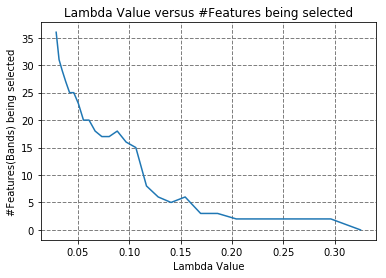

In [21]:
%matplotlib inline
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(lambda_,num_feature)
plt.xlabel('Lambda Value')
plt.ylabel('#Features(Bands) being selected')
plt.title('Lambda Value versus #Features being selected')
plt.show()

### 从上图可以看出随着惩罚系数的增大，被选择的波段（特征）
- 由于惩罚系数的增大使得算法试图将系数矩阵变得更加稀疏，从而减小了选中的波段（特征）数目

## 对拟合好的模型模型进行测试评估

In [22]:
from test import data_preprocessing#数据预处理模块
preprocessing = data_preprocessing(indian_pines.data,indian_pines.label)
preprocessing.reshape_data()#修改数据维度
preprocessing.delet_unlabel()#删除未标记数据
preprocessing.standardize()#对所有有标签数据标准化处理
preprocessing.onehot_encoder_for_label()#对标签进行onehot编码
preprocessing.augment_data()#对数据矩阵X进行增广

/home/ysq/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 对不同惩罚系数下得到的系数矩阵可视化

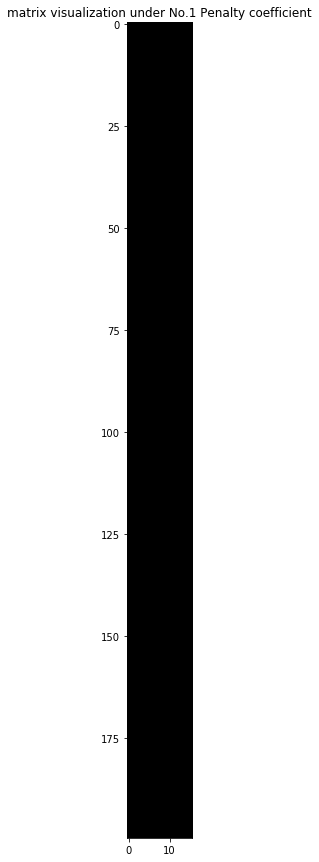

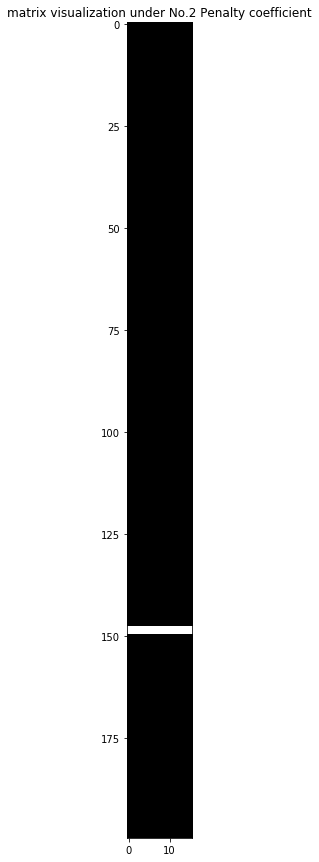

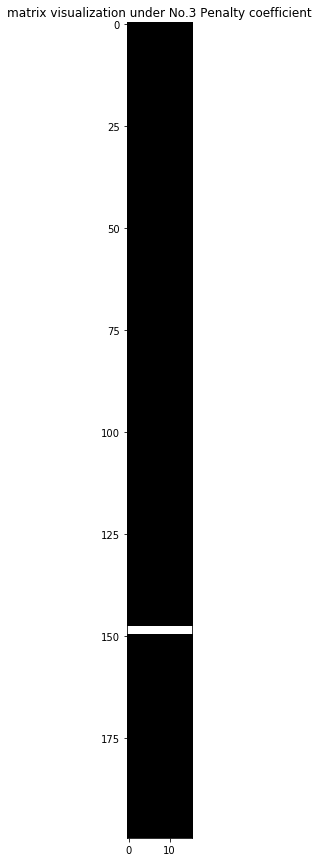

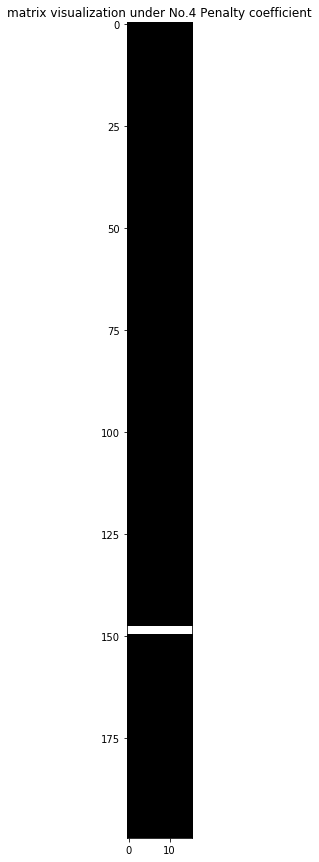

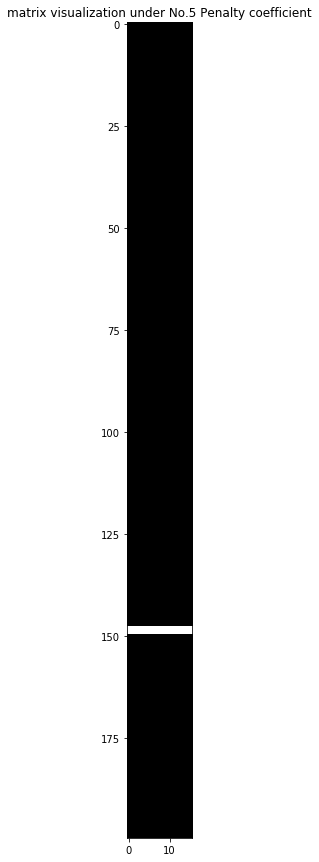

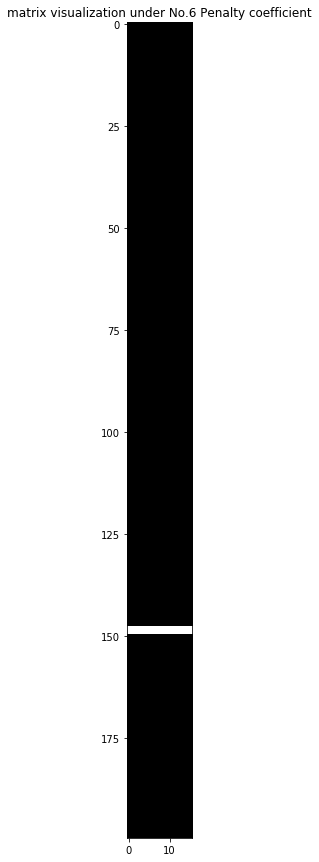

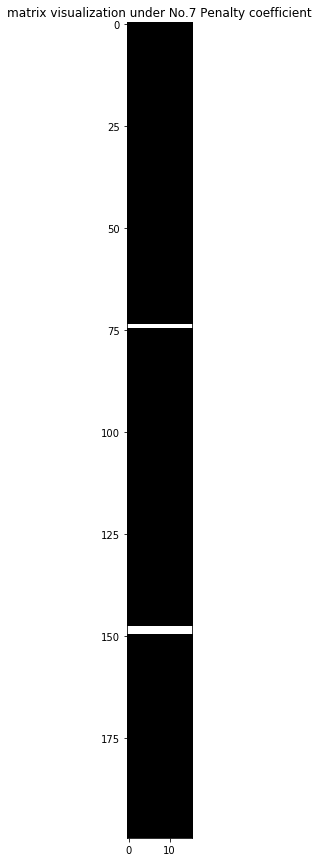

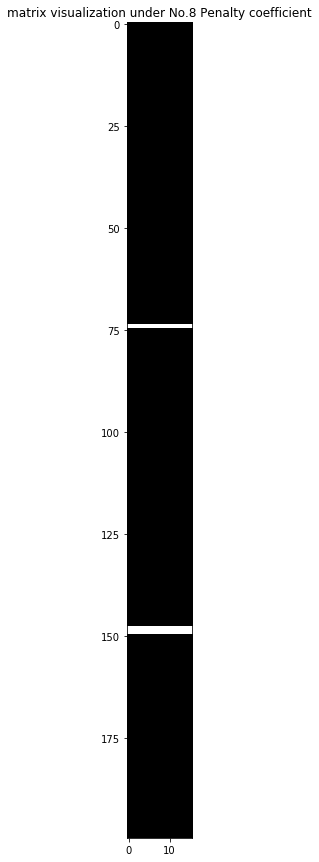

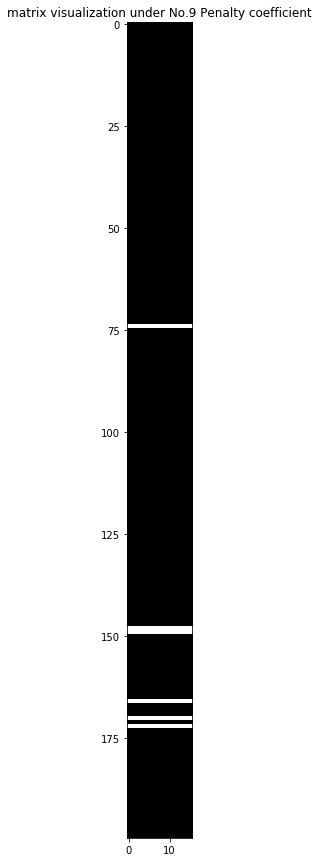

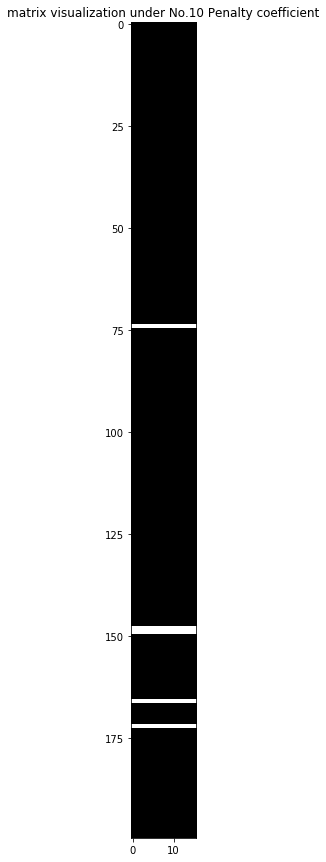

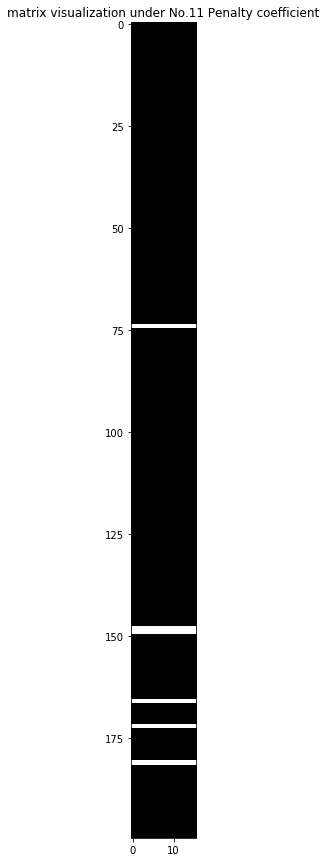

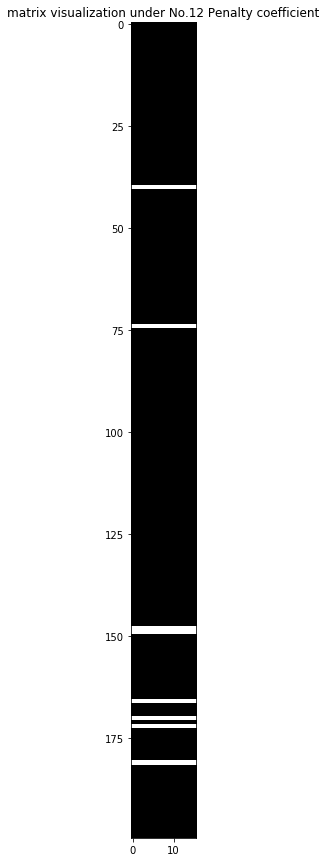

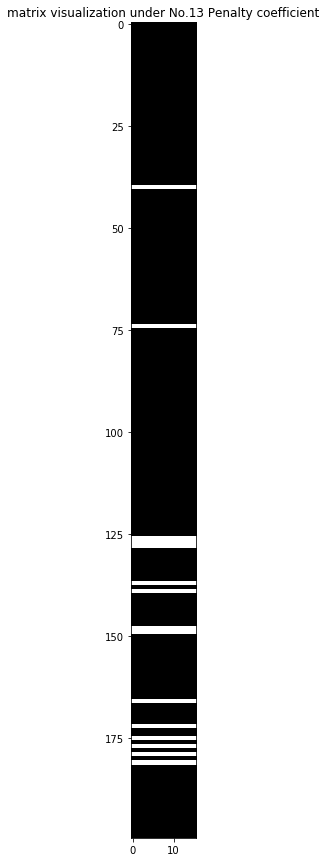

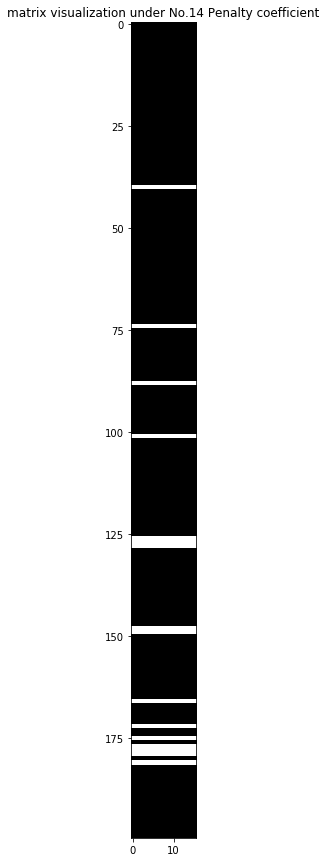

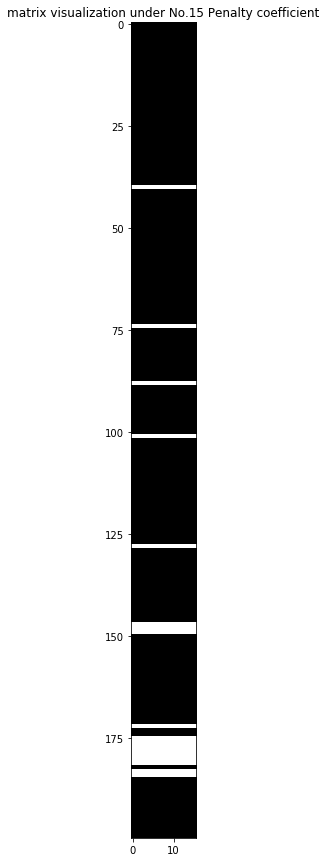

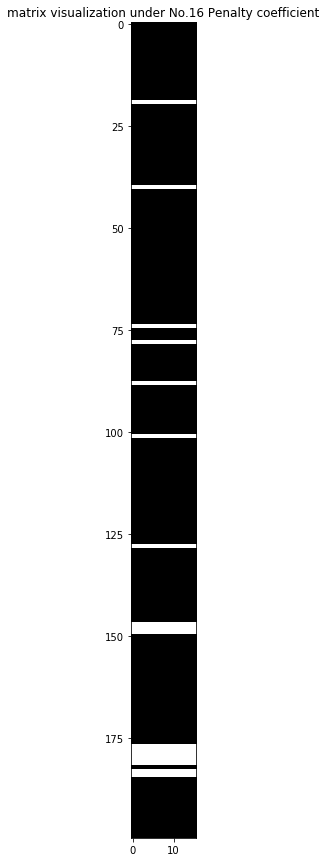

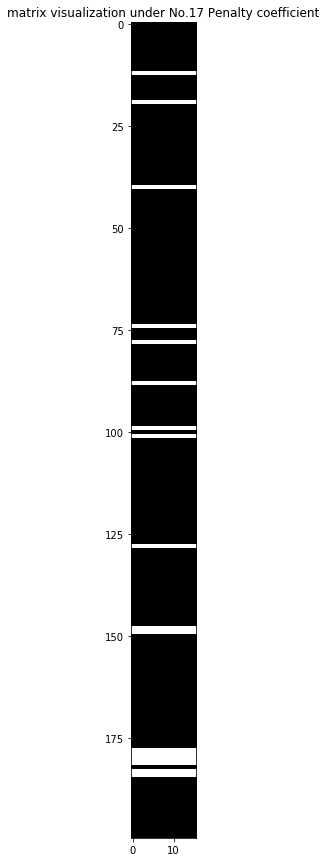

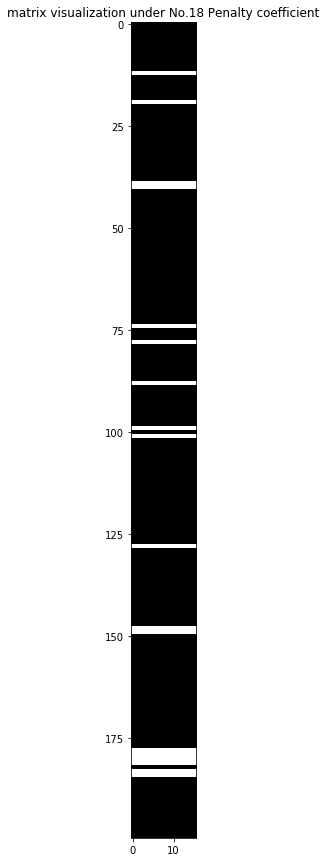

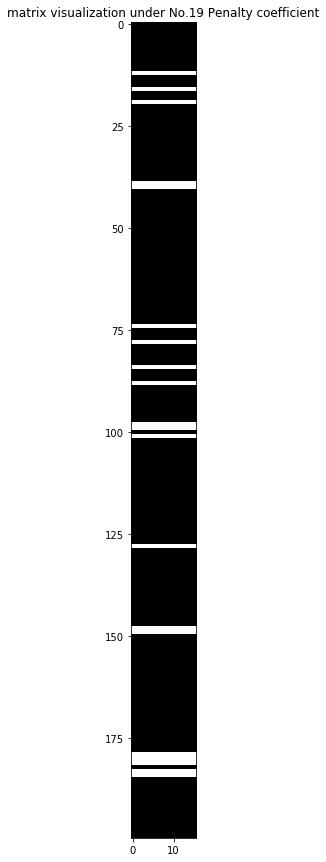

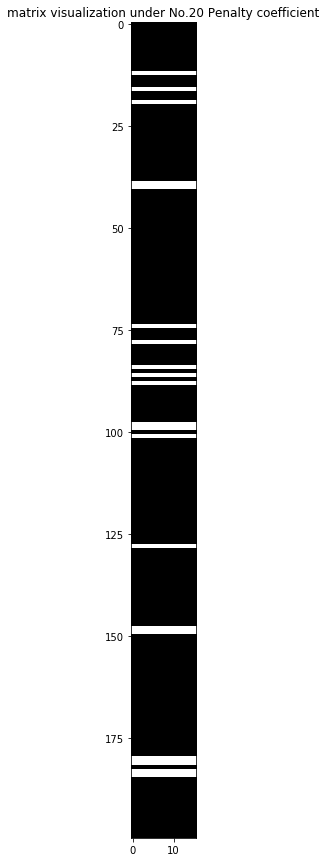

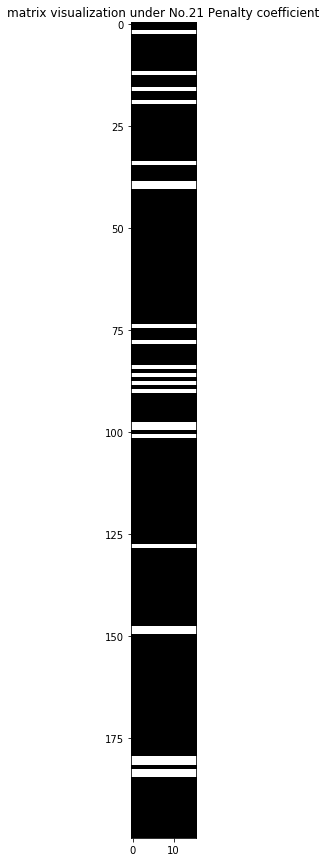

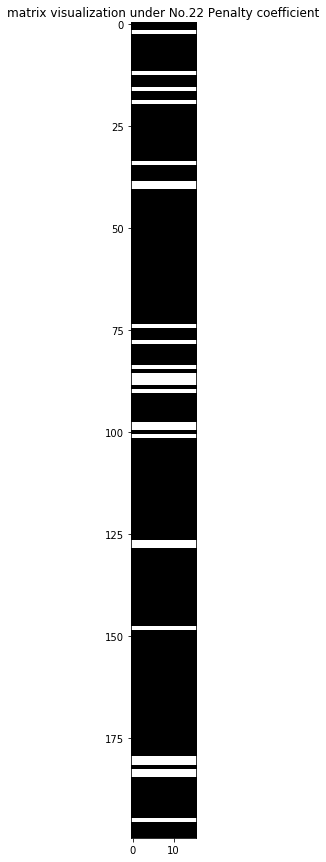

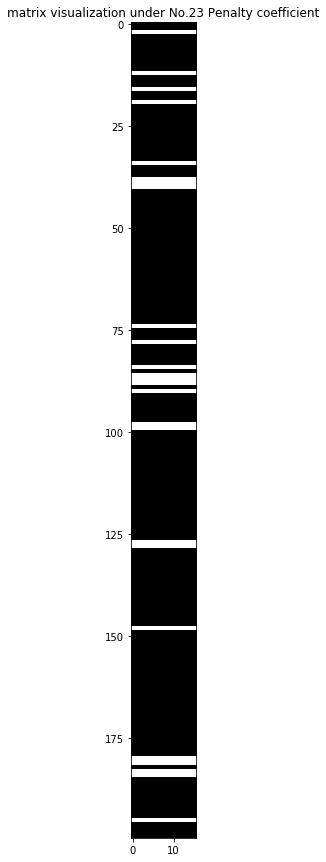

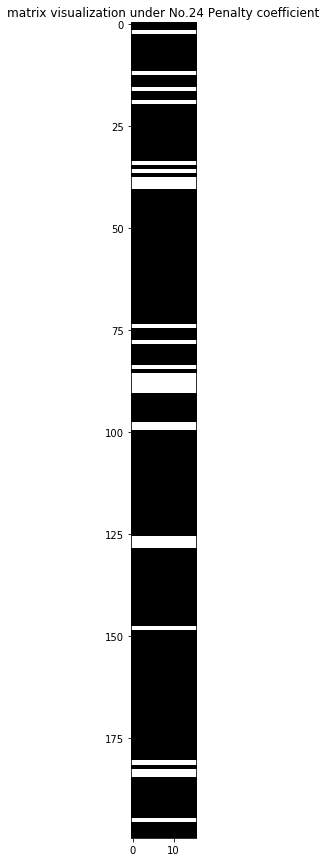

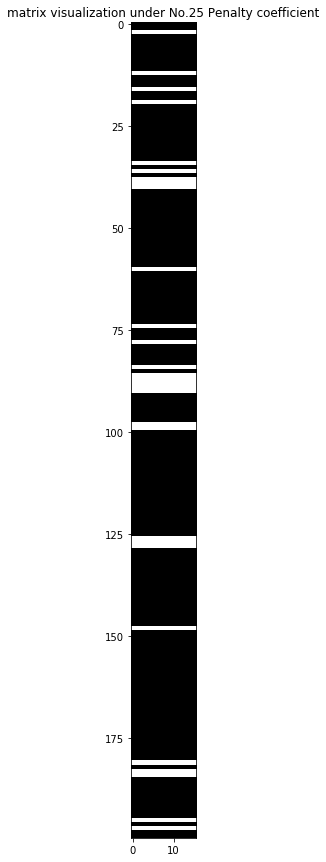

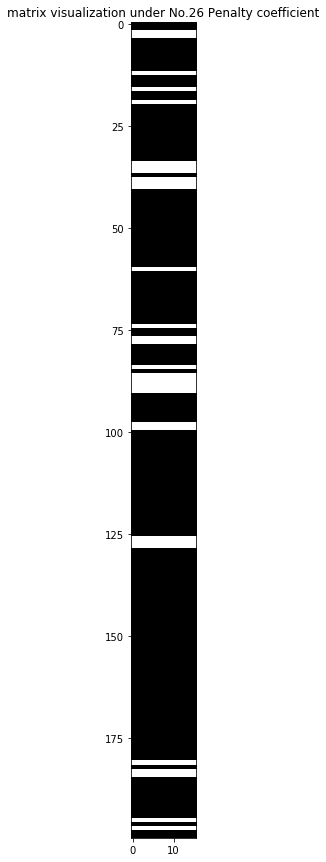

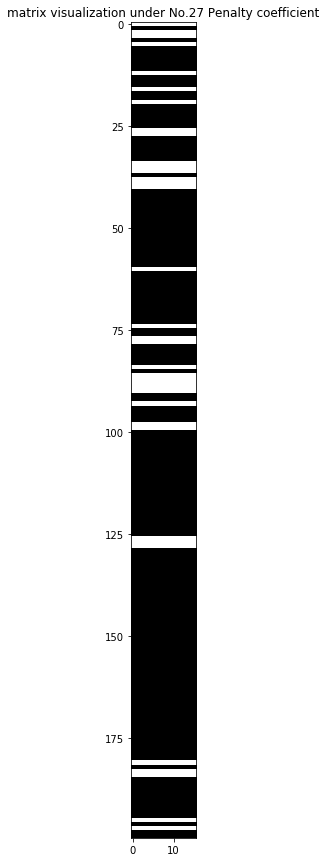

In [23]:
#尝试获取训练好的参数
beta = np.array(fit['beta'])
plt.rcParams['figure.figsize'] = (15.0, 15.0)
for i in range(beta.shape[2]):
    """
        遍历不同惩罚系数lambda对应的系数矩阵
    """
    now_matrix = beta[:,:,i].T
    plot_list = []#绘图使用的矩阵
    for k in range(now_matrix.shape[0]):
        row_vec = []#行向量
        for j in range(now_matrix.shape[1]):
            if now_matrix[k,j] != 0:
                #非零元素用白色
                row_vec.append(255)#255为白色
            else:
                row_vec.append(0)#零元素用黑色，0位黑色
        plot_list.append(np.array(row_vec))
    plot_matrix = np.array(plot_list)
    plt.imshow(plot_matrix,cmap='gray')
    plt.title(f'matrix visualization under No.{i+1} Penalty coefficient')
    plt.show()

## 对不同系数下的模型进行测试
***
- 获取系数
- 建立评价准则函数（多类逻辑回归模型，softmax函数）
- 获取在该系数下的分类结果
- 此处系数指：训练好的模型中的['a0']['beta']['lambdau']三个参数,a0为模型的偏置系数，beta为系数矩阵,lambdau为模型的惩罚系数

In [24]:
def get_ith_parameter(fit_dic,i):
    """
        方法说明：
        获取训练好的模型中的lambdau的第i个变量(i ∈ {0,1,...,99}，共100个值)
        lambda_(惩罚系数)以及该惩罚系数所对应的a0中的一个行向量,beta中的一个矩阵
        
        返回值：
        一个字典，包含惩罚系数lambda_,系数矩阵B(这个B由beta和a0共同组成)
        注意惩罚系数的值随着i的增大而减小,i越小，系数矩阵B越稀疏
        参数说明：
        fit_dic是一个训练好的glmnet模型所返回的包含系数信息的字典
        i为用户期望取的第几个惩罚参数对应的所有参数的下标 对于Indian Pines，i取值为0~100
    """
    #获取惩罚系数
    lambda_ = fit_dic['lambdau'][i]
    #获取偏置行向量
    B_0 = fit_dic['a0'][:,i].reshape(1,-1)#取第i列并转置为行向量
    #获取第i个惩罚系数对应的系数矩阵
    B_ = np.array(fit_dic['beta'])[:,:,i].T
    #将B_和B_0合并生成系数矩阵B，B为201*16
    B = np.concatenate((B_0,B_),axis=0)#合并矩阵，按行合并axis = 0
    return {'lambda':lambda_,'B':B}#返回一个字典

In [25]:
import test
###请查看test.py中的信息
preprocessing = data_preprocessing(indian_pines.data,indian_pines.label)
preprocessing.reshape_data()#修改数据维度
preprocessing.delet_unlabel()#删除未标记数据
preprocessing.standardize()#对所有有标签数据标准化处理
preprocessing.onehot_encoder_for_label()#对标签进行onehot编码
preprocessing.augment_data()#对数据矩阵X进行增广
#获取预处理后的数据和标签
X = preprocessing.X #数据矩阵
Y = preprocessing.Y #标签矩阵                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/home/ysq/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 定义预测函数
***
- 定义为单个样本生成预测概率的行向量的方法
- 定义为单个样本生成0/1预测行向量的方法
- 定义为所有样本生成0/1预测矩阵的方法

In [26]:
import math #计算指数函数
def predict_for_one_sample(X,i,B):
    """
        参数说明：
        X为数据矩阵,i为期望预测的样本的序号，B为参数矩阵
        ------------------------------------------
        该函数使用softmax regression对传入序号对应的样本进行多分类预测
        返回一个预测向量，代表该样本属于各类的概率
    """
    row_vec = X[i]#获取行向量
    predict = []#构建预测概率向量的空列表
    denominator = 0#softmax regression的分母
    for j in range(B.shape[1]):
        """
            在各类之间循环计算分母
        """
        column_vec = B[:,j]#获取B的第j个列向量
        foo = math.exp(row_vec@column_vec)#@为计算向量内积
        predict.append(foo)
        denominator += foo
    #计算各类概率
    predict = np.array(predict)#list -> ndarray
    predict /= denominator
    return predict
def generate_max_row_vec_from_predict(predict_vec):
    """
        该函数是为绘制混淆矩阵做准备的函数
        ----------------------------------------------------
        参数 predict_vec:由predict_for_one_sample生成的向量
        将predict行向量变为0,1向量，最大值处变为1，作为预测类别，剩下的地方填0
    """
    index = np.argmax(predict_vec)#获取最大值的下标
    vec = []#预测值向量
    for i in range(predict_vec.shape[0]):
        """
            遍历所有类
        """
        if i == index:#若当前下标为最大值对应的 添加1否则添加0
            vec.append(1)
        else:
            vec.append(0)
    return np.array(vec)#返回0/1预测向量

In [27]:
def generate_prediction_matrix_for_all(X,i):
    """
        参数：i为用户希望进行预测的惩罚系数的下标，这个下标用于获取系数矩阵B
        对X中所有样本，生成在系数矩阵为第i个惩罚系数对应的系数矩阵B时的预测结果矩阵
    """
    B = get_ith_parameter(fit,i)['B']#获取系数矩阵
    predict_list = []#预测列表
    for i in range(X.shape[0]):
        """
            遍历所有样本行向量
        """
        predict_list.append(generate_max_row_vec_from_predict(predict_for_one_sample(X,i,B)))
        #获取预测向量并添加至列表中
    return np.array(predict_list)        

## 绘制混淆矩阵

In [31]:
from sklearn.metrics import confusion_matrix#计算混淆矩阵

labels = []#标签信息列表
for j in range(16):
    """
        共16类，生成标签
    """
    labels.append(j)
predict_matrix = generate_prediction_matrix_for_all(X,i=26)
predict_vec = np.argmax(predict_matrix,axis=1)#生成一个列向量，该列向量元素为矩阵的每行最大值的下标
truth_vec = np.argmax(Y,axis=1)
matrix = confusion_matrix(y_true=truth_vec,y_pred=predict_vec,labels=labels)

In [32]:
def generate_confusion_matrix(X,i,Y):
    """
        为第i个惩罚系数下对应的系数矩阵进行的测试生成混淆矩阵
        Y为真值0/1矩阵
        X为数据矩阵
    """
    labels = []#标签信息列表
    for j in range(16):
        """
            共16类，生成标签
        """
        labels.append(j)
    predict_matrix = generate_prediction_matrix_for_all(X,i=i)#生成预测矩阵
    predict_vec = np.argmax(predict_matrix,axis=1)#生成一个列向量，该列向量元素为矩阵的每行最大值的下标
    truth_vec = np.argmax(Y,axis=1)#真值
    matrix = confusion_matrix(y_true=truth_vec,y_pred=predict_vec,labels=labels)#混淆矩阵
    return matrix

In [33]:
import seaborn as sn#用于绘制混淆矩阵
def plot_cm(matrix):
    """
        绘制混淆矩阵的函数
    """
    guess = []#预测标签
    fact = []#
    for i in range(16):
        guess.append(str(i))
        fact.append(str(i))
    df_cm = pd.DataFrame(matrix,
                          index = guess,
                          columns = fact)
    plt.figure(figsize=(20,20))
    sn.heatmap(df_cm,annot=True,fmt='d',cmap=plt.cm.Blues)#绘制混淆矩阵
    plt.xlabel('Predict',fontsize = 18)
    plt.ylabel('Ture',fontsize = 18)
    plt.title('Confusion Matrix',fontsize = 20)
    plt.show()

### 为所有惩罚系数绘出混淆矩阵

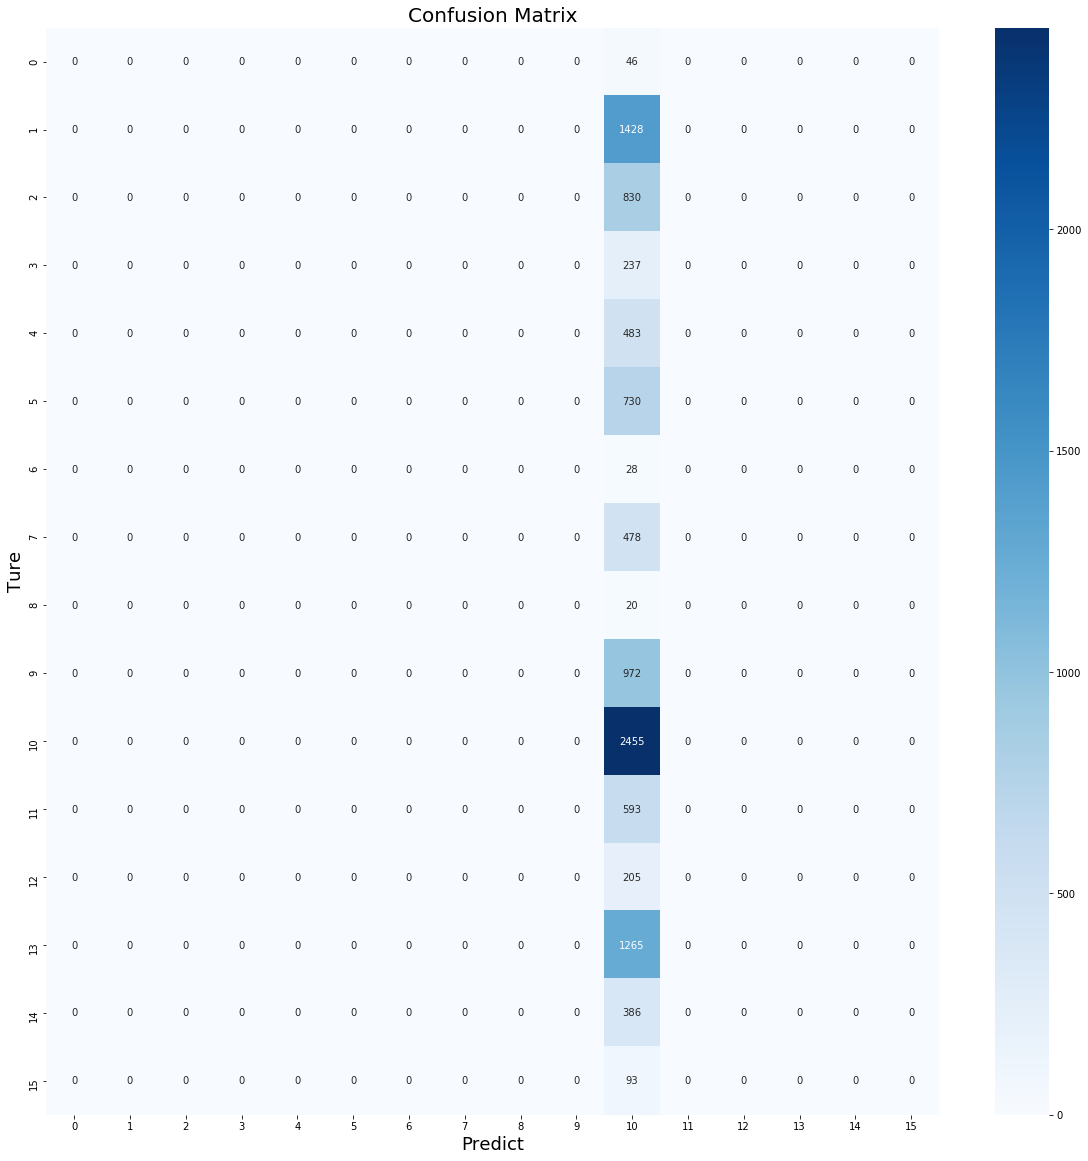

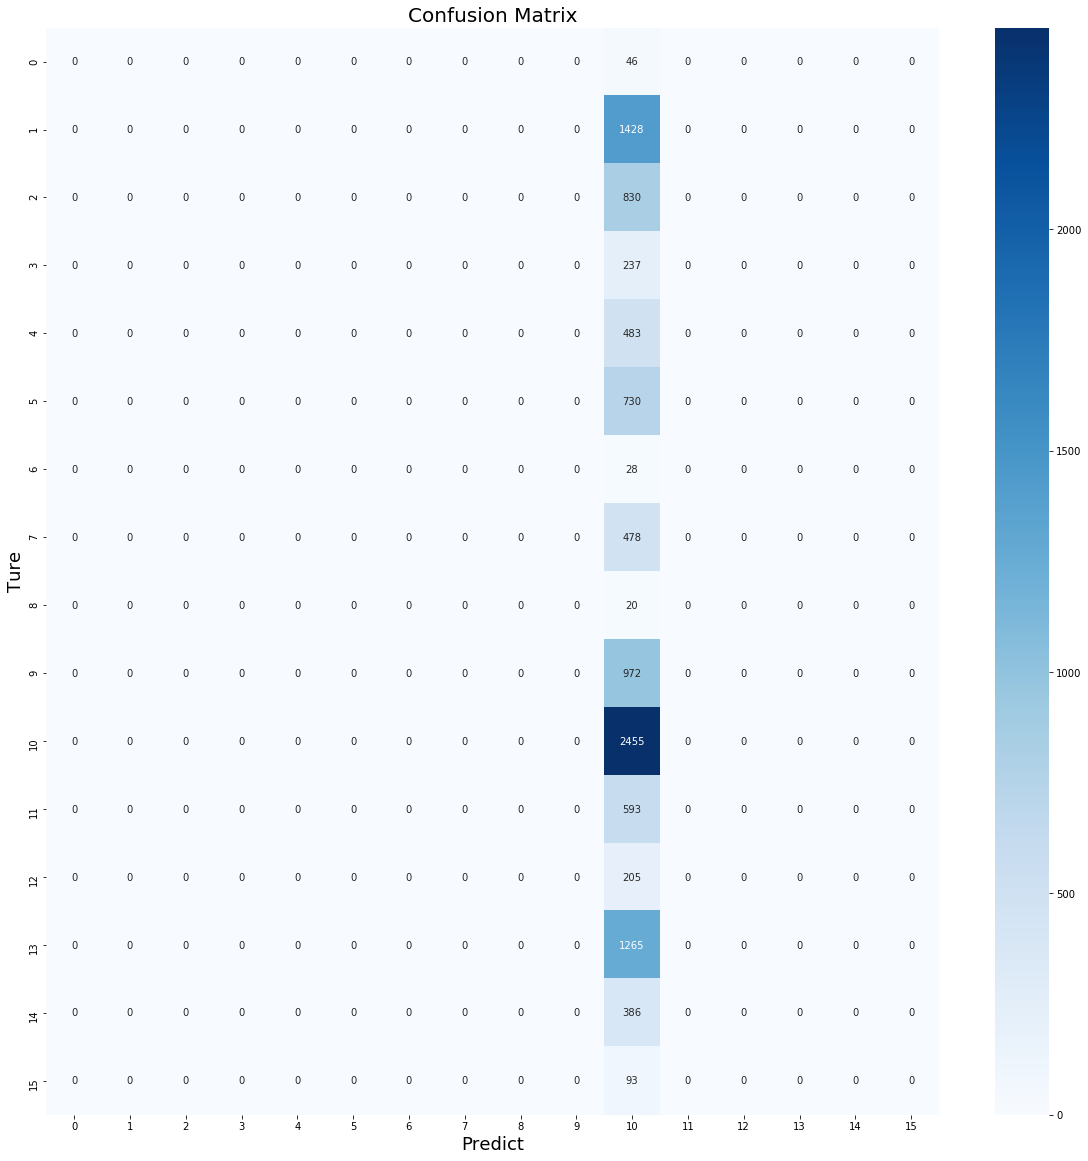

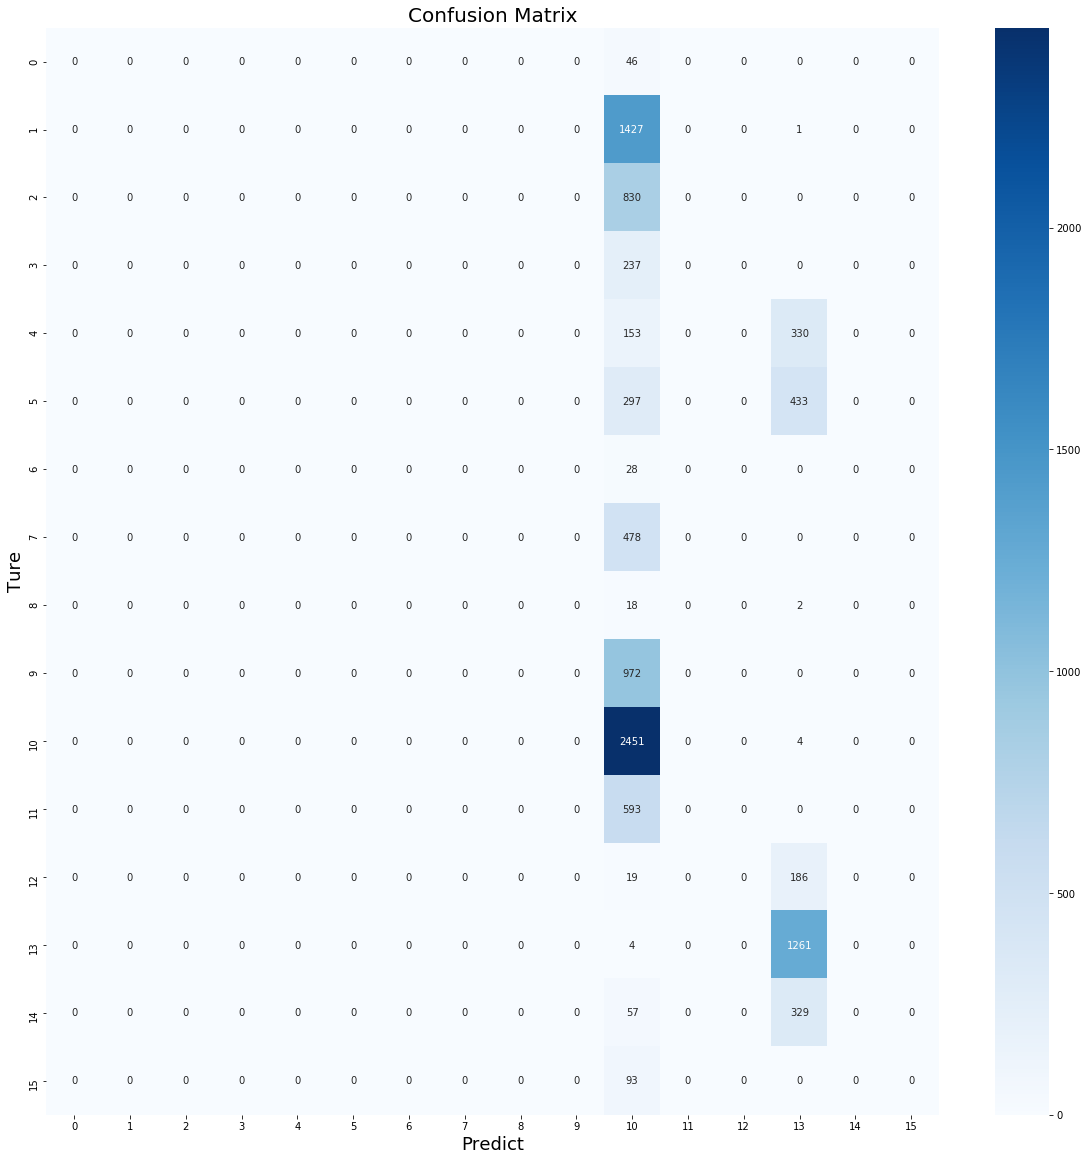

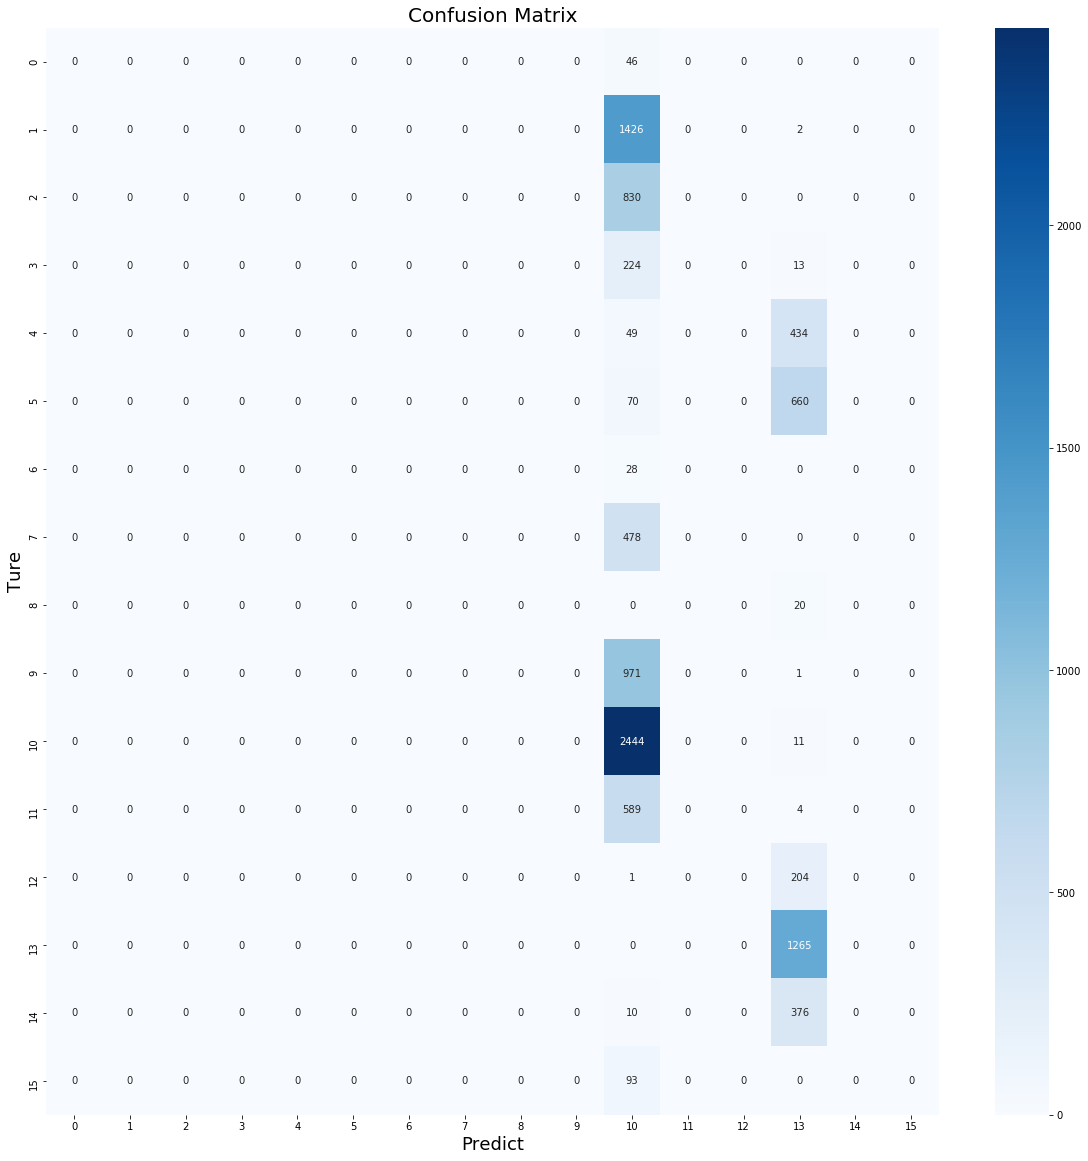

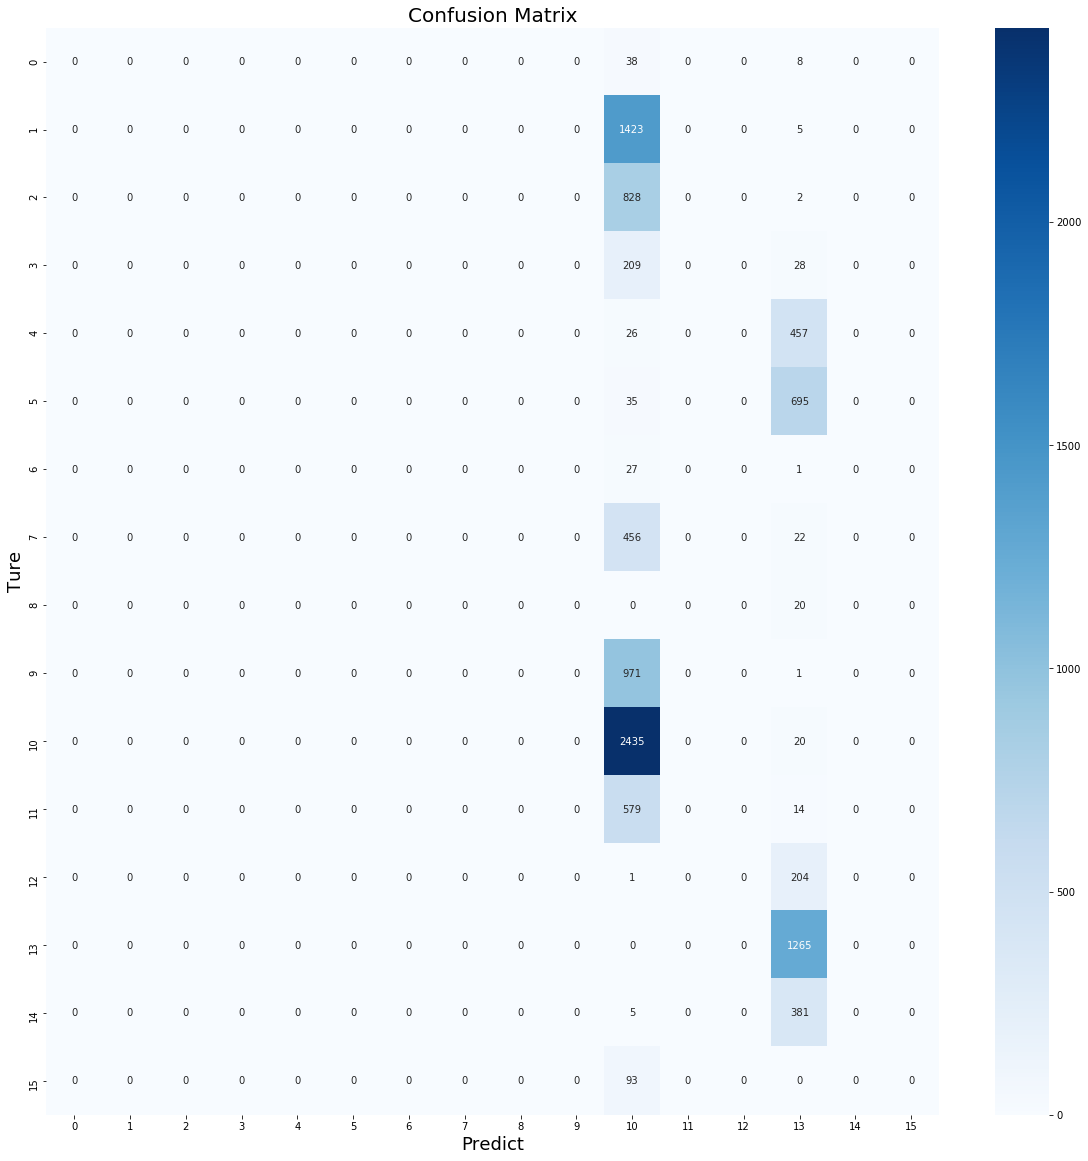

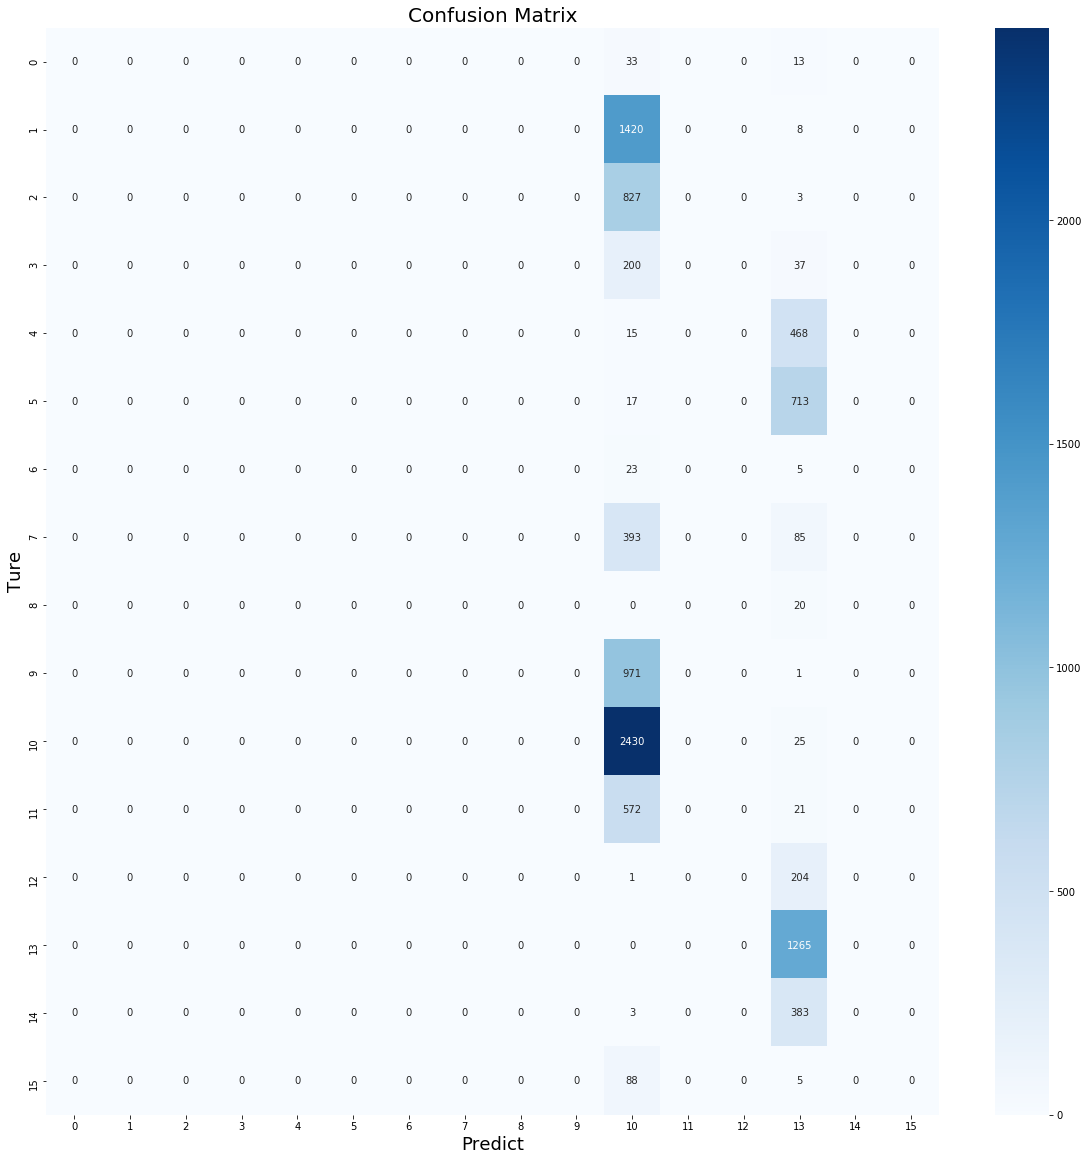

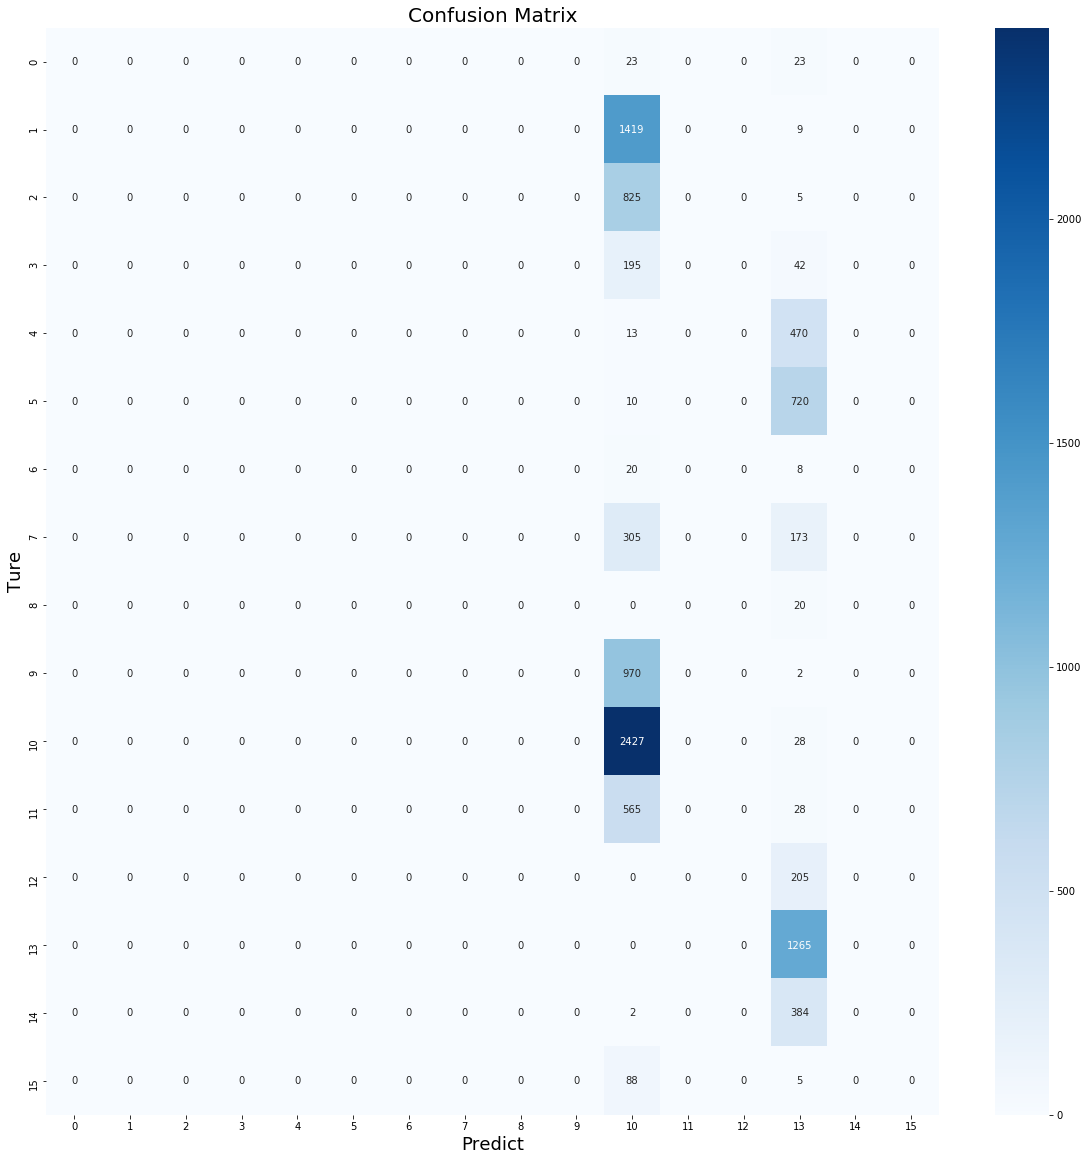

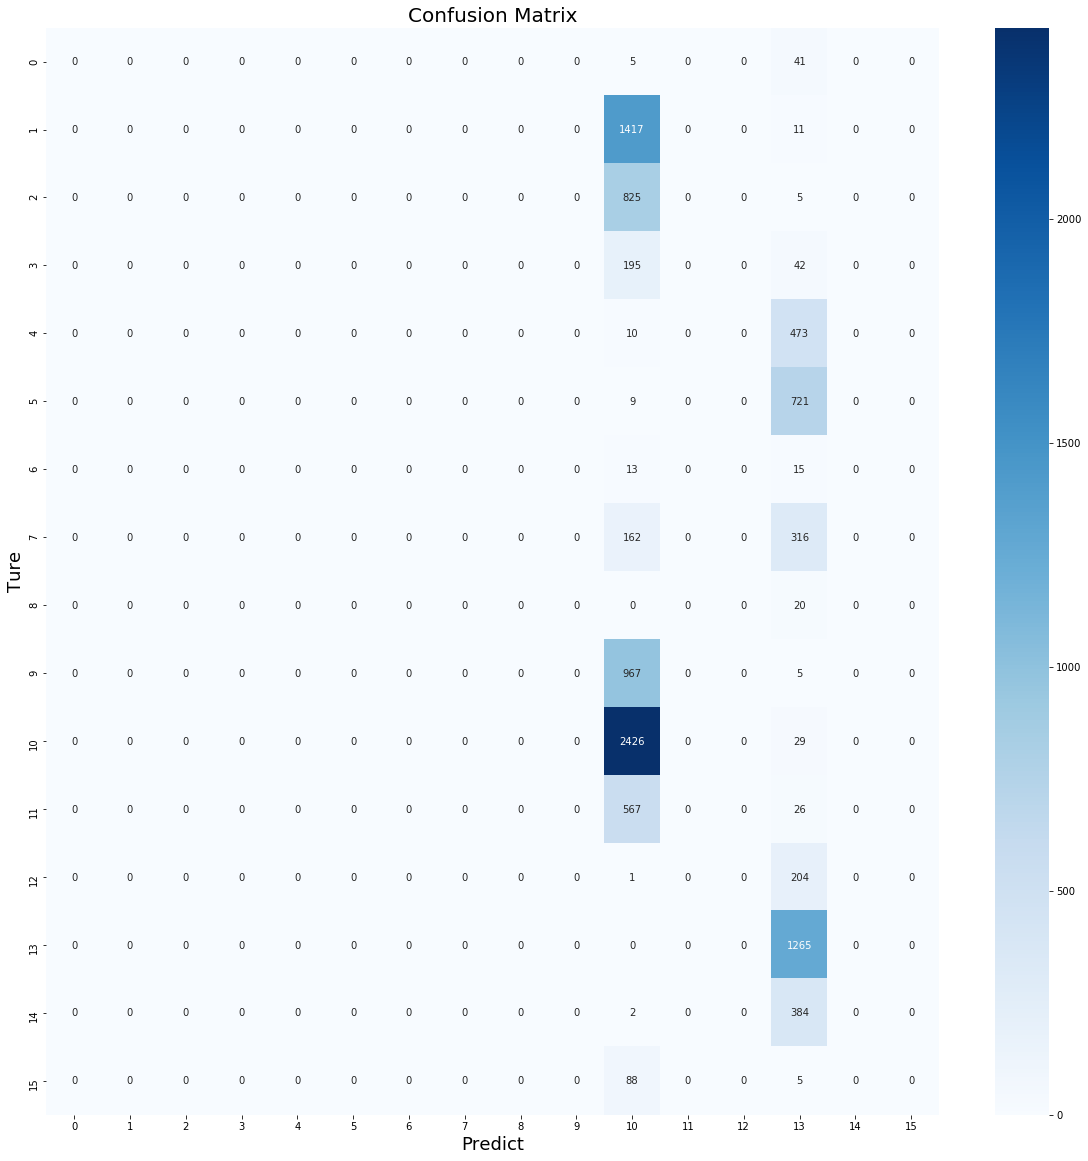

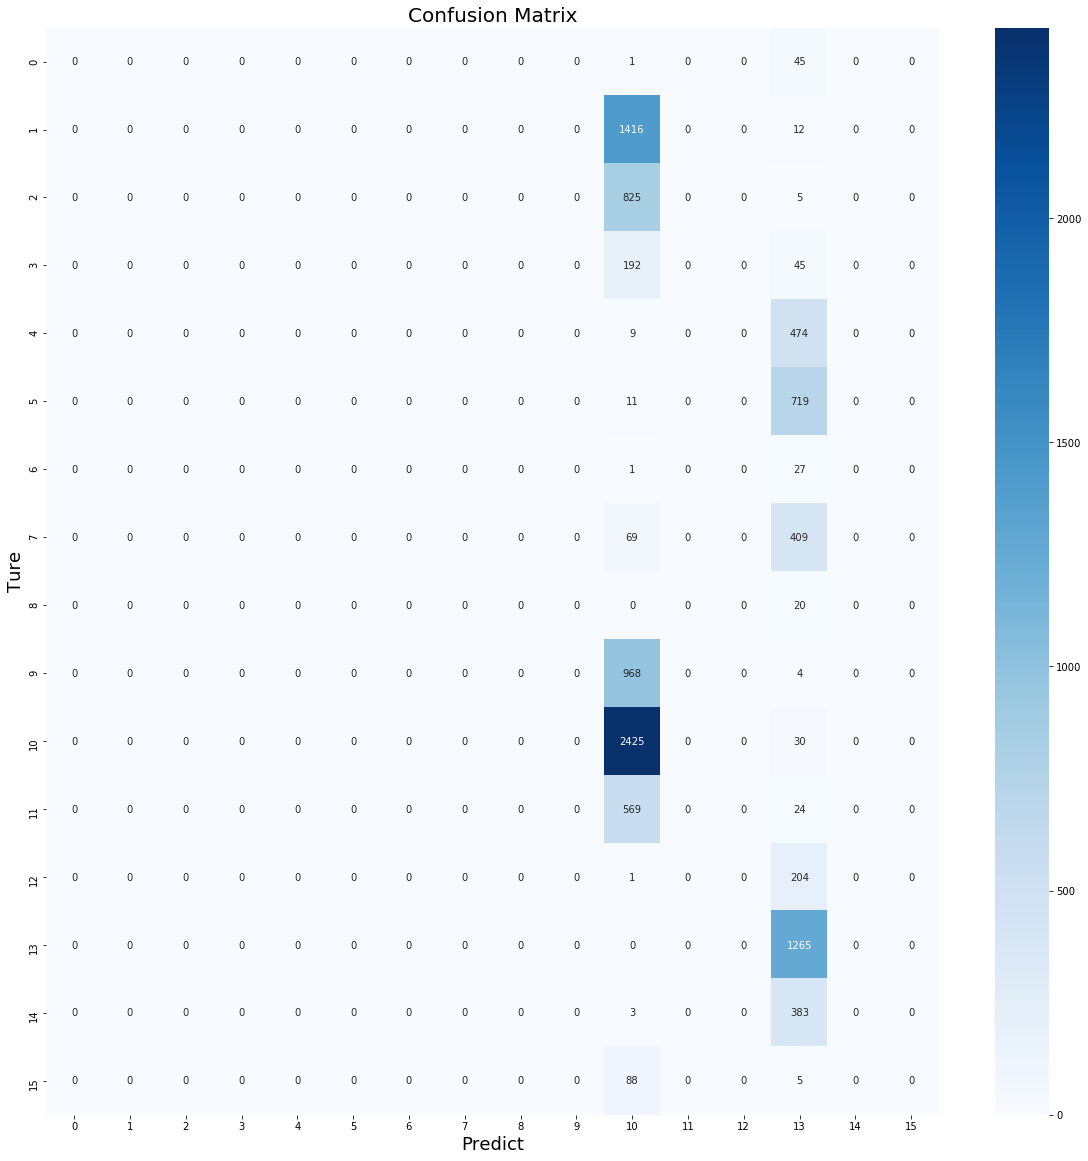

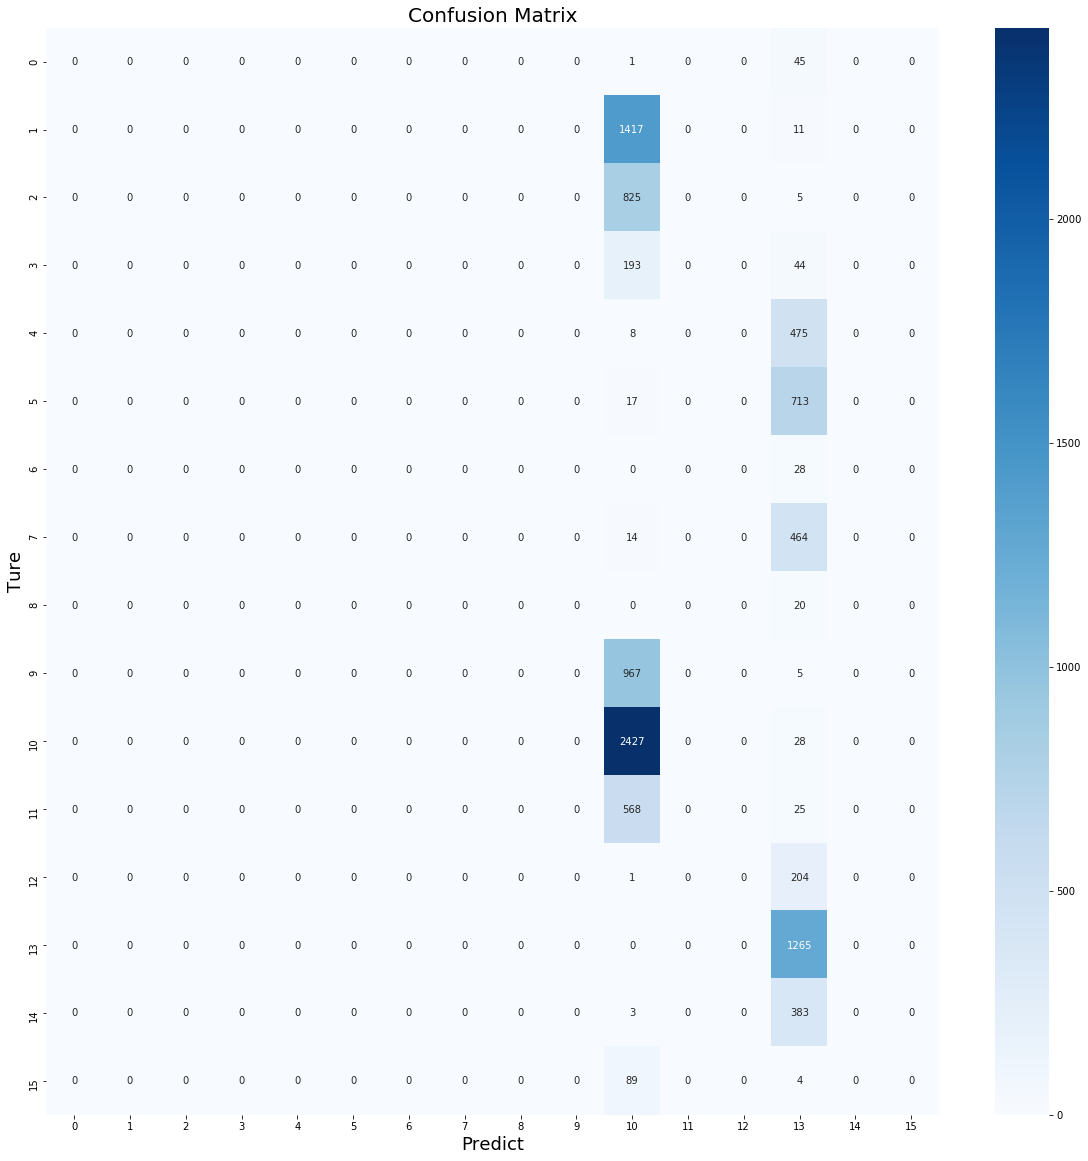

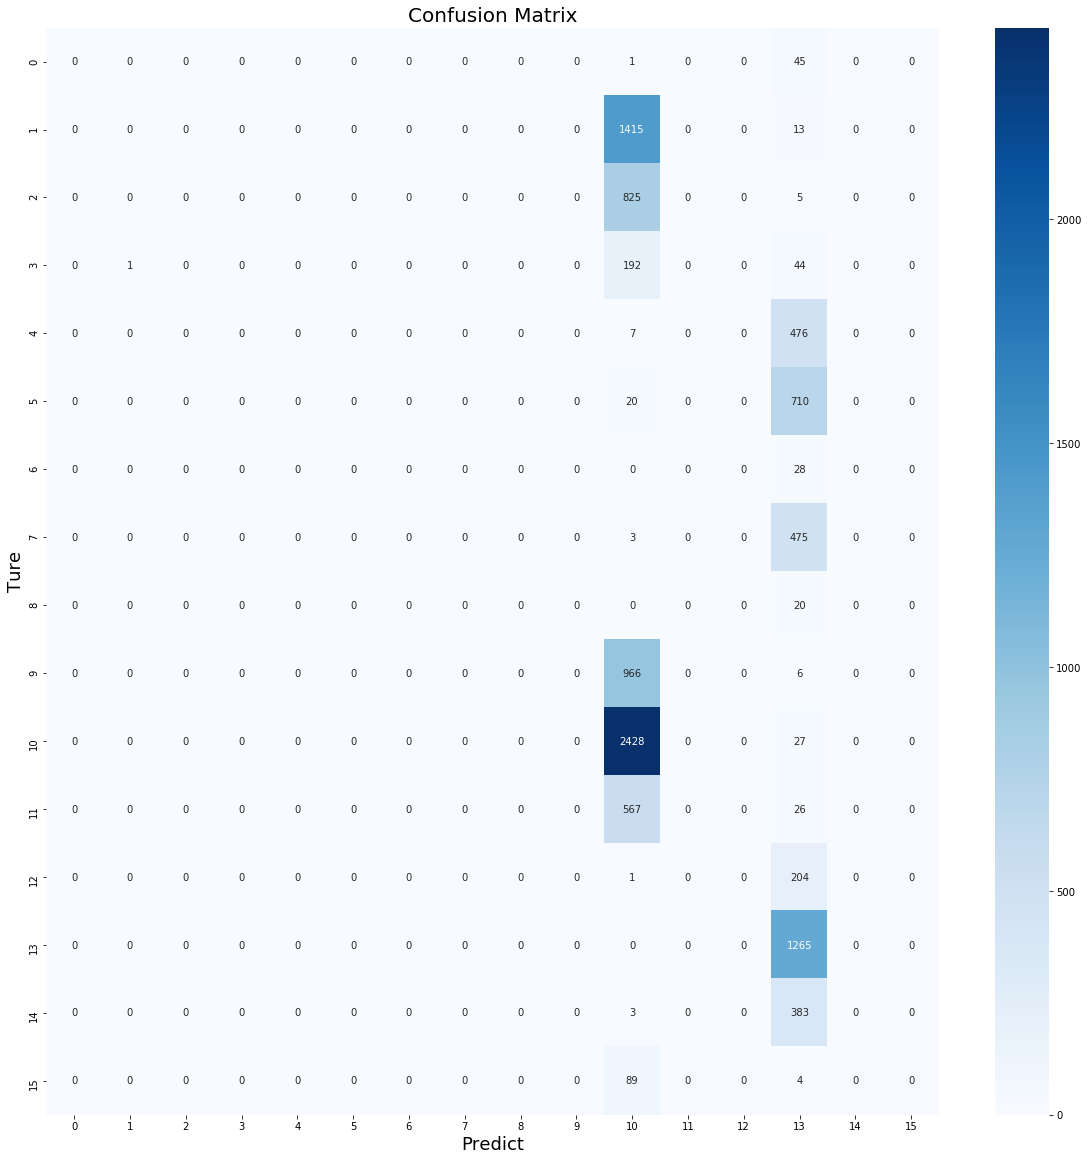

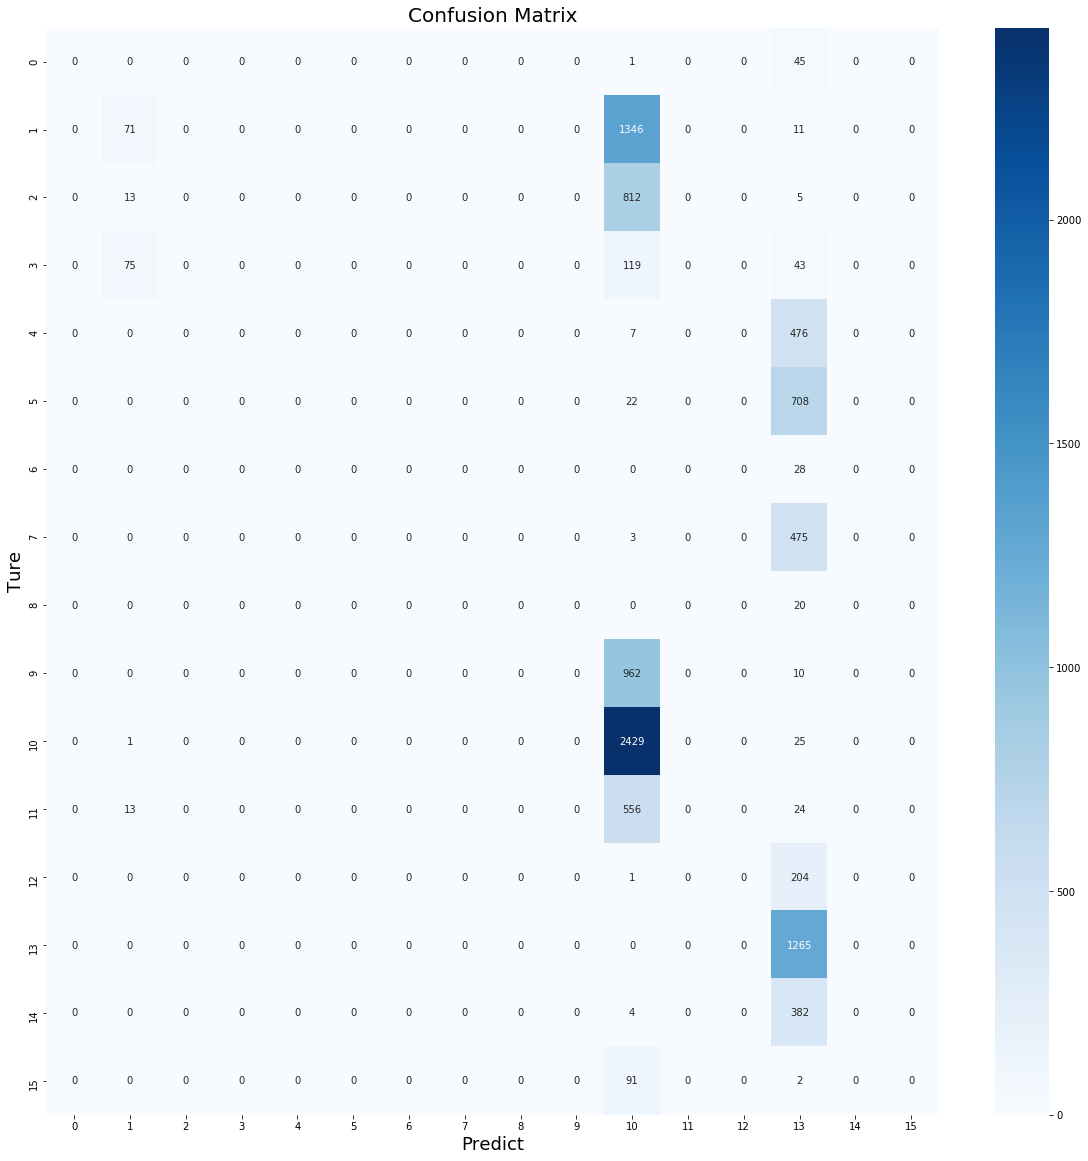

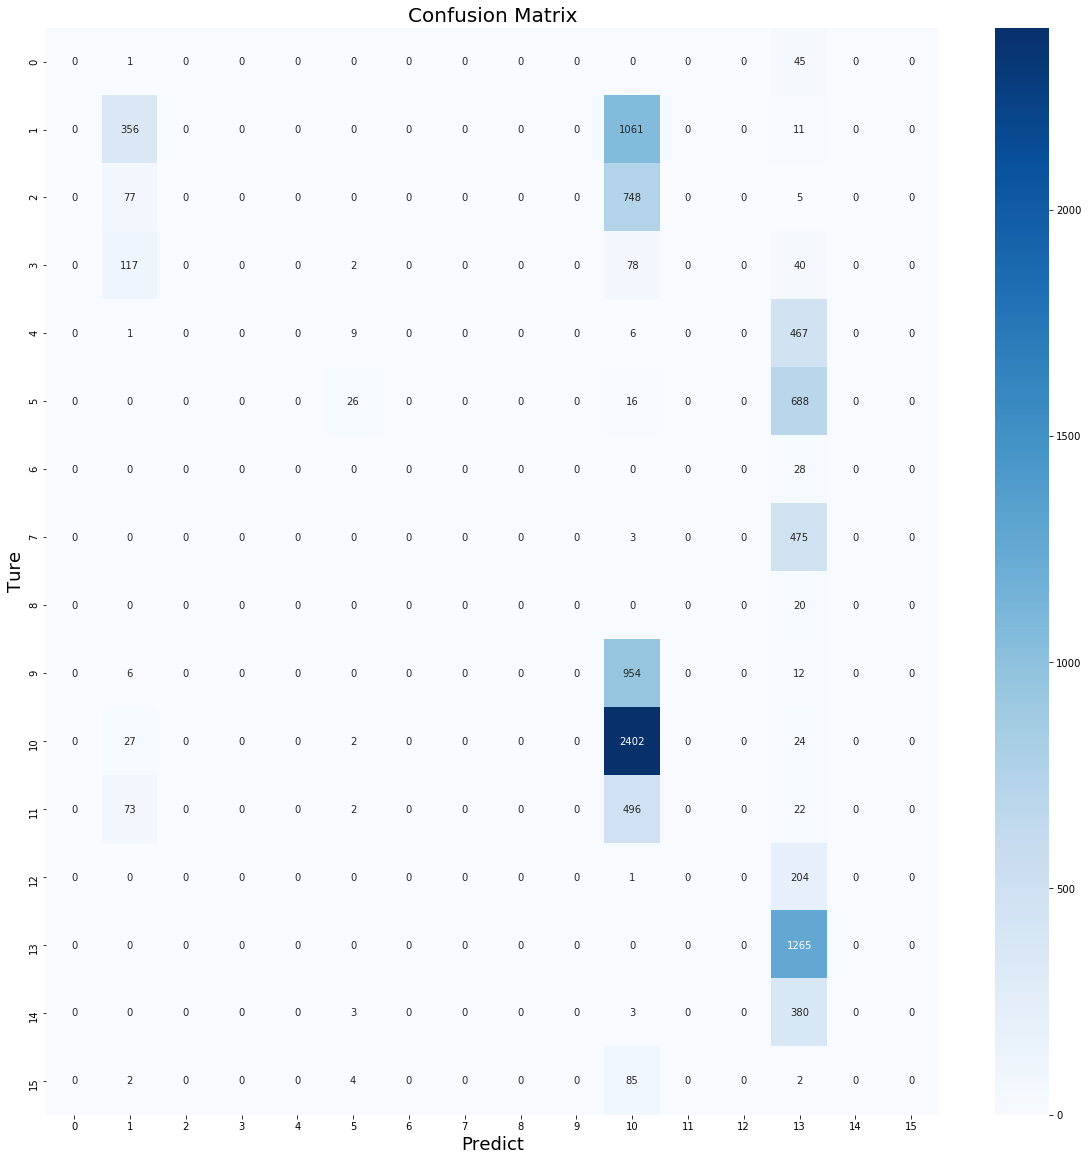

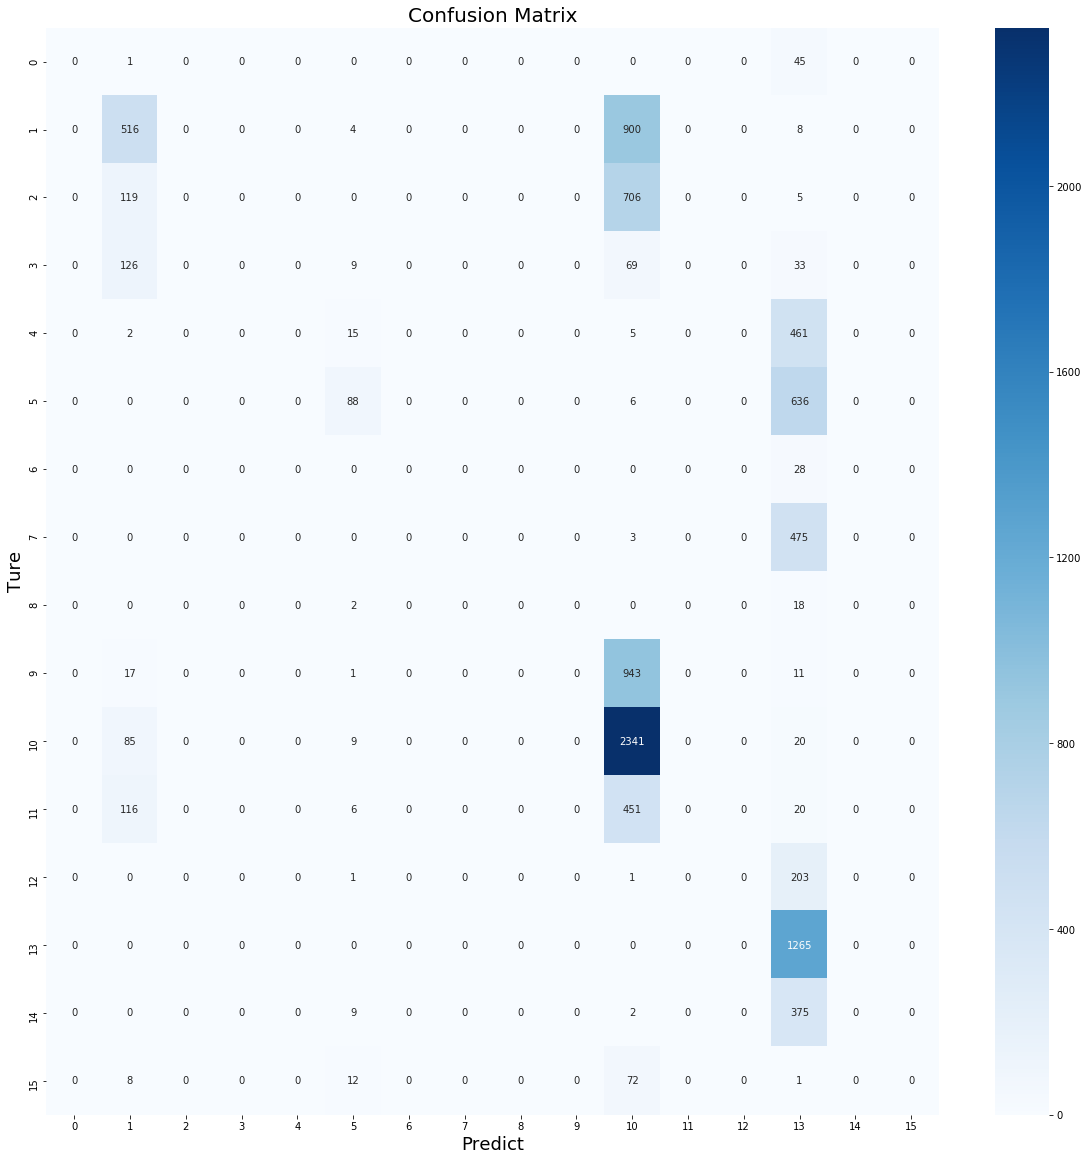

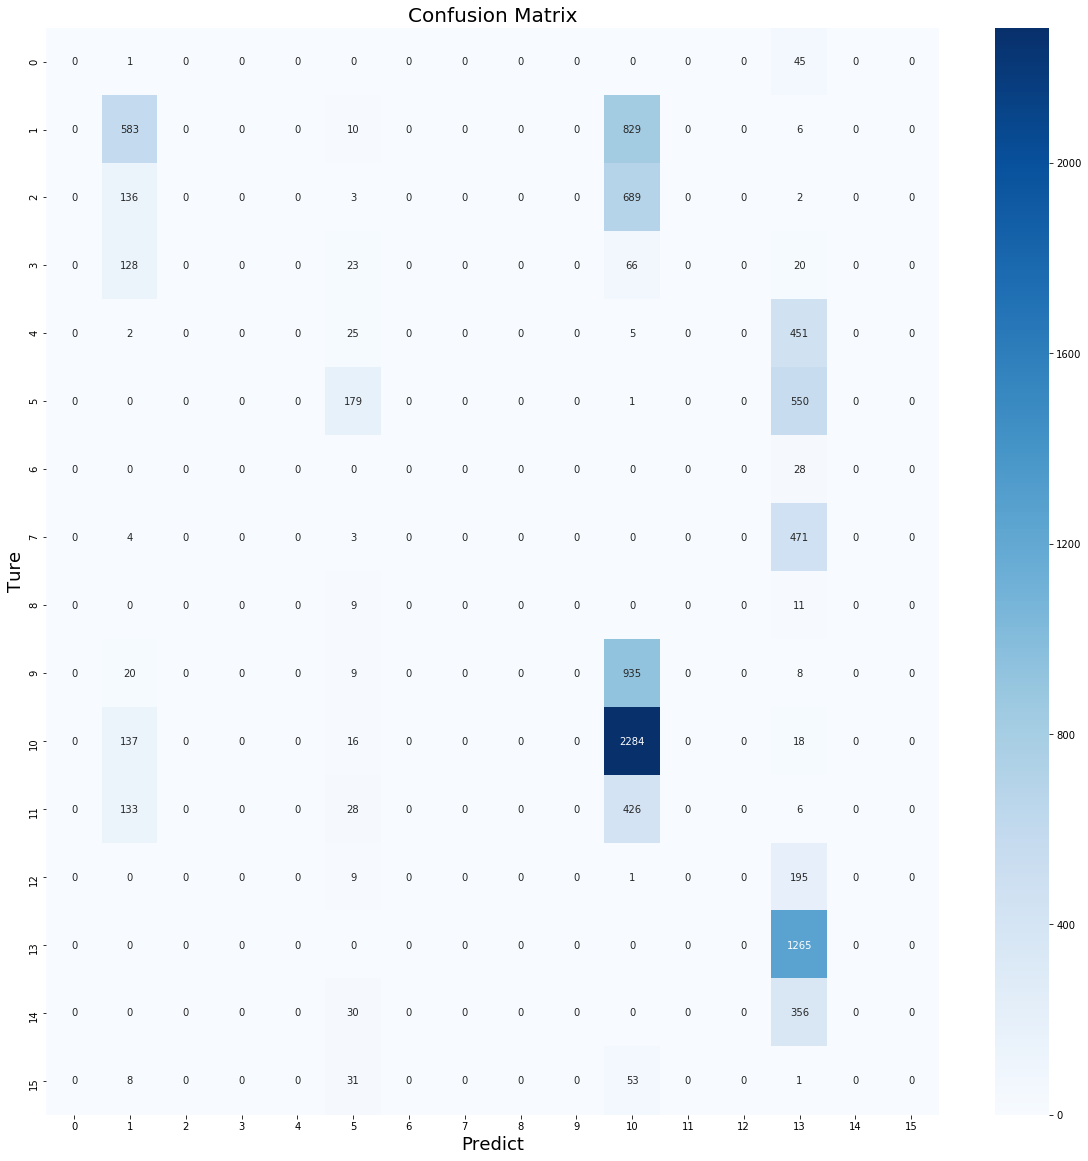

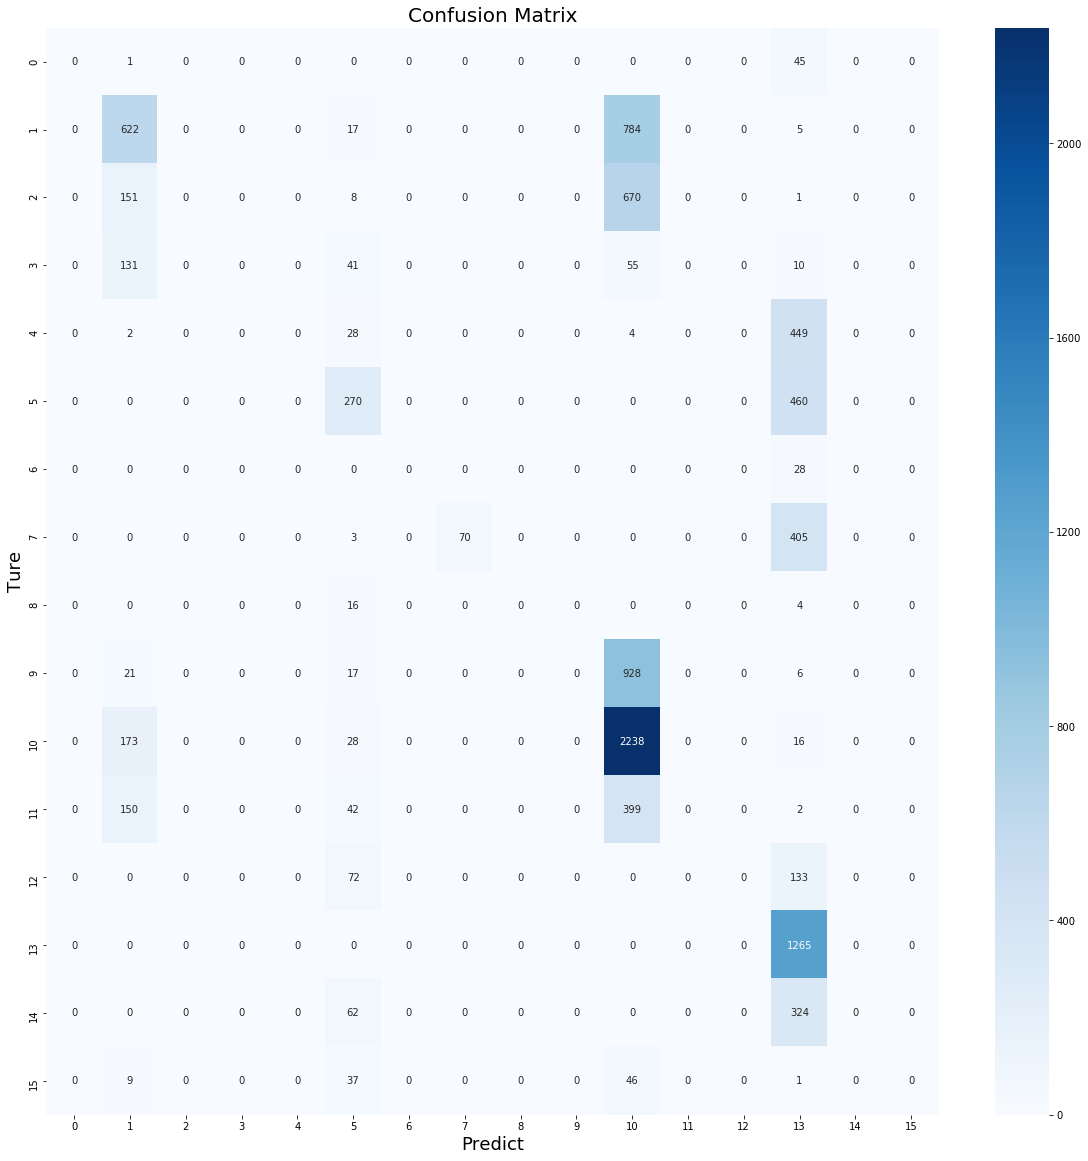

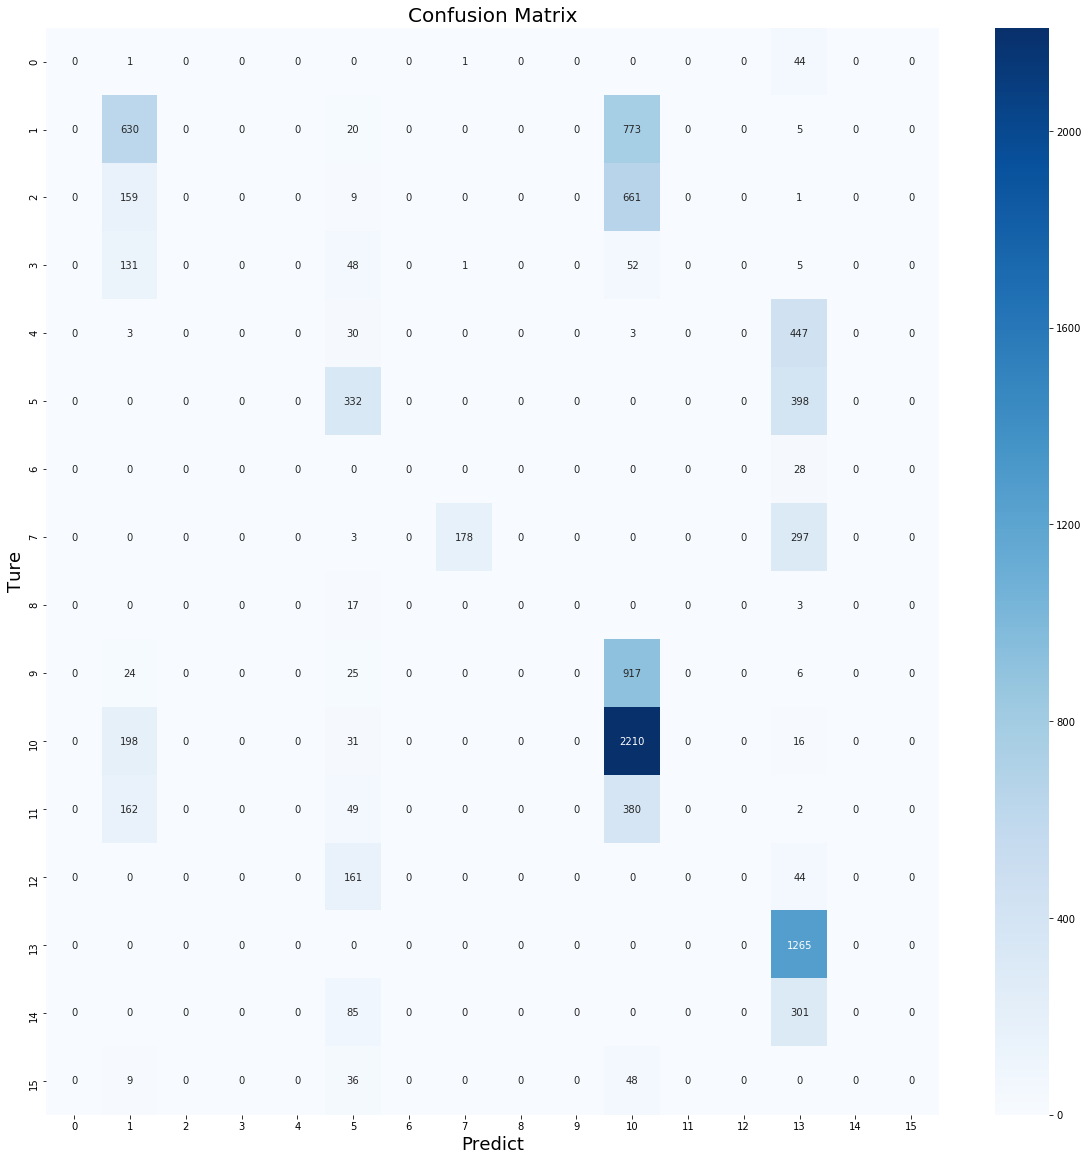

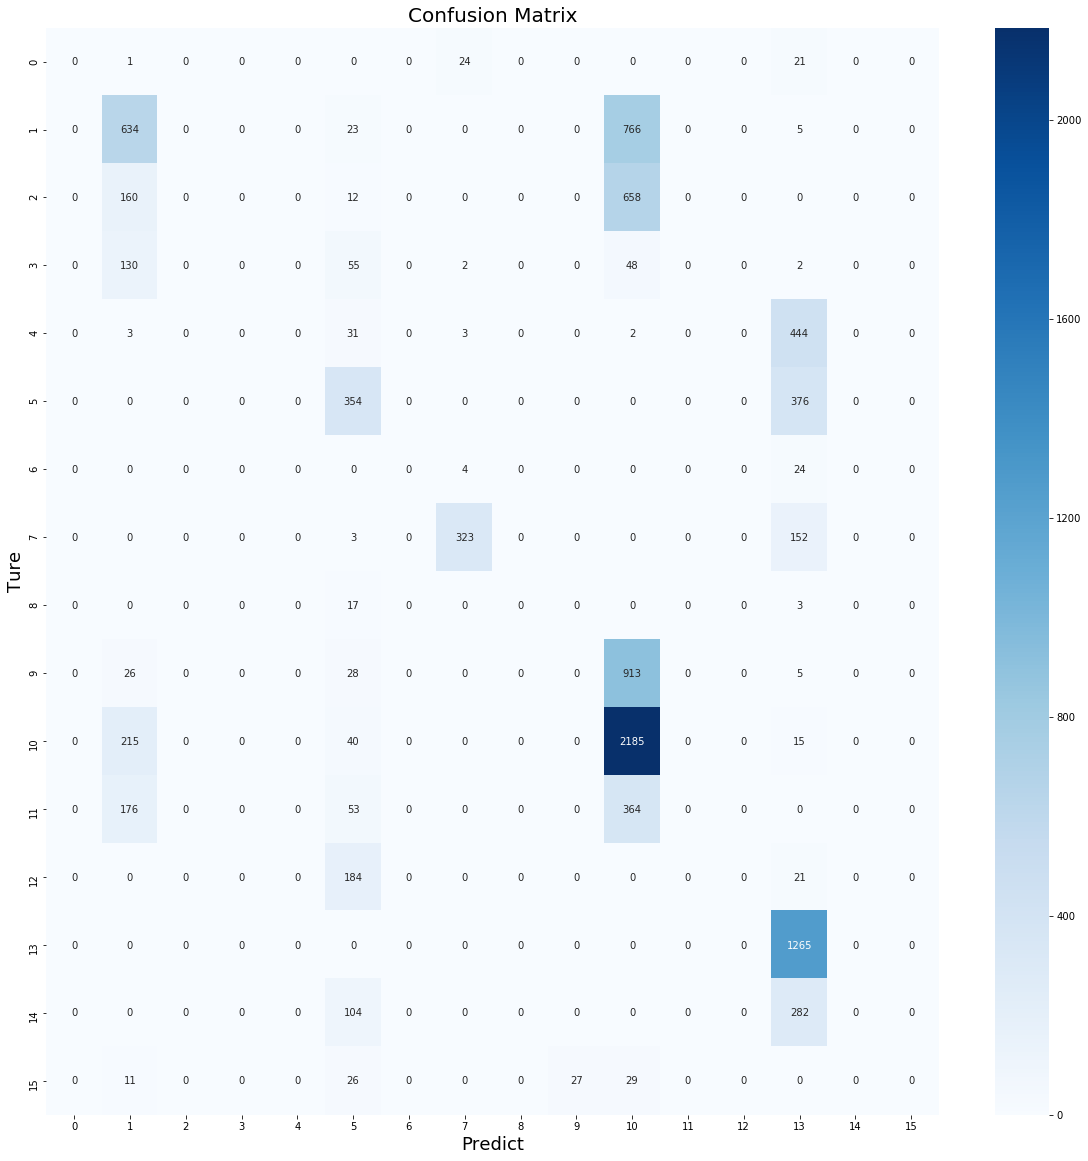

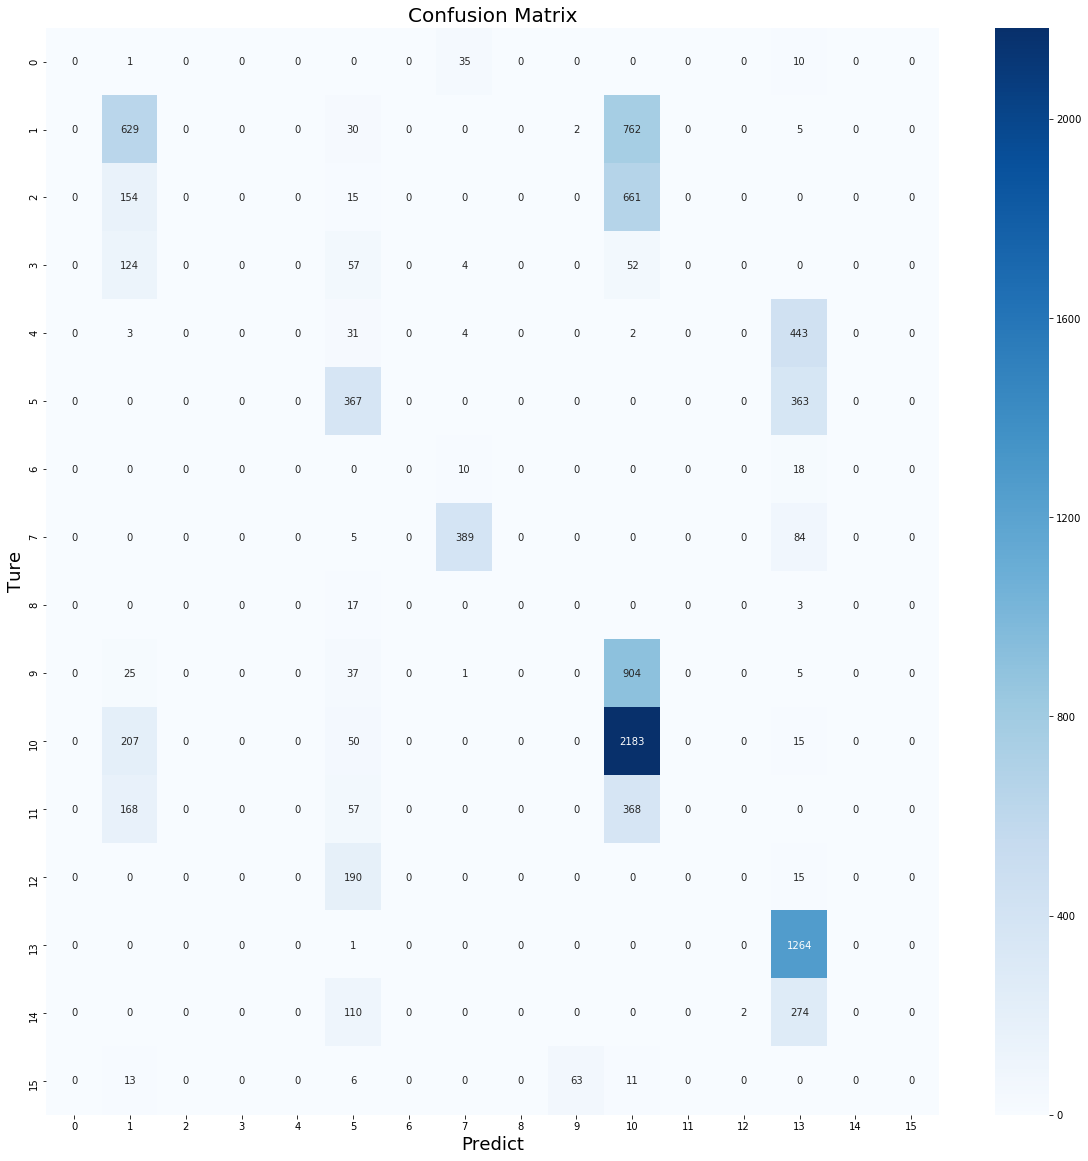

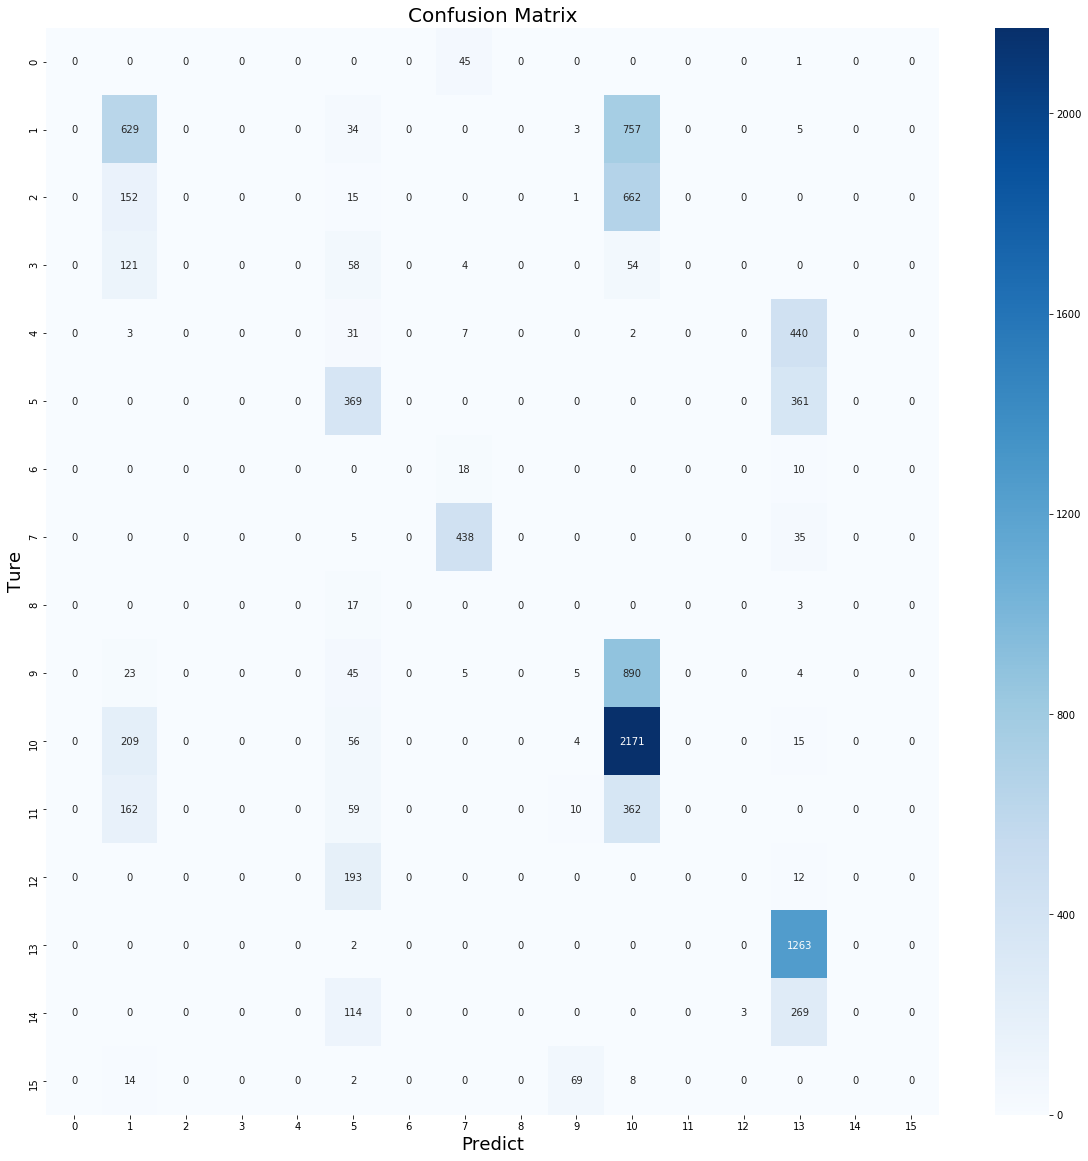

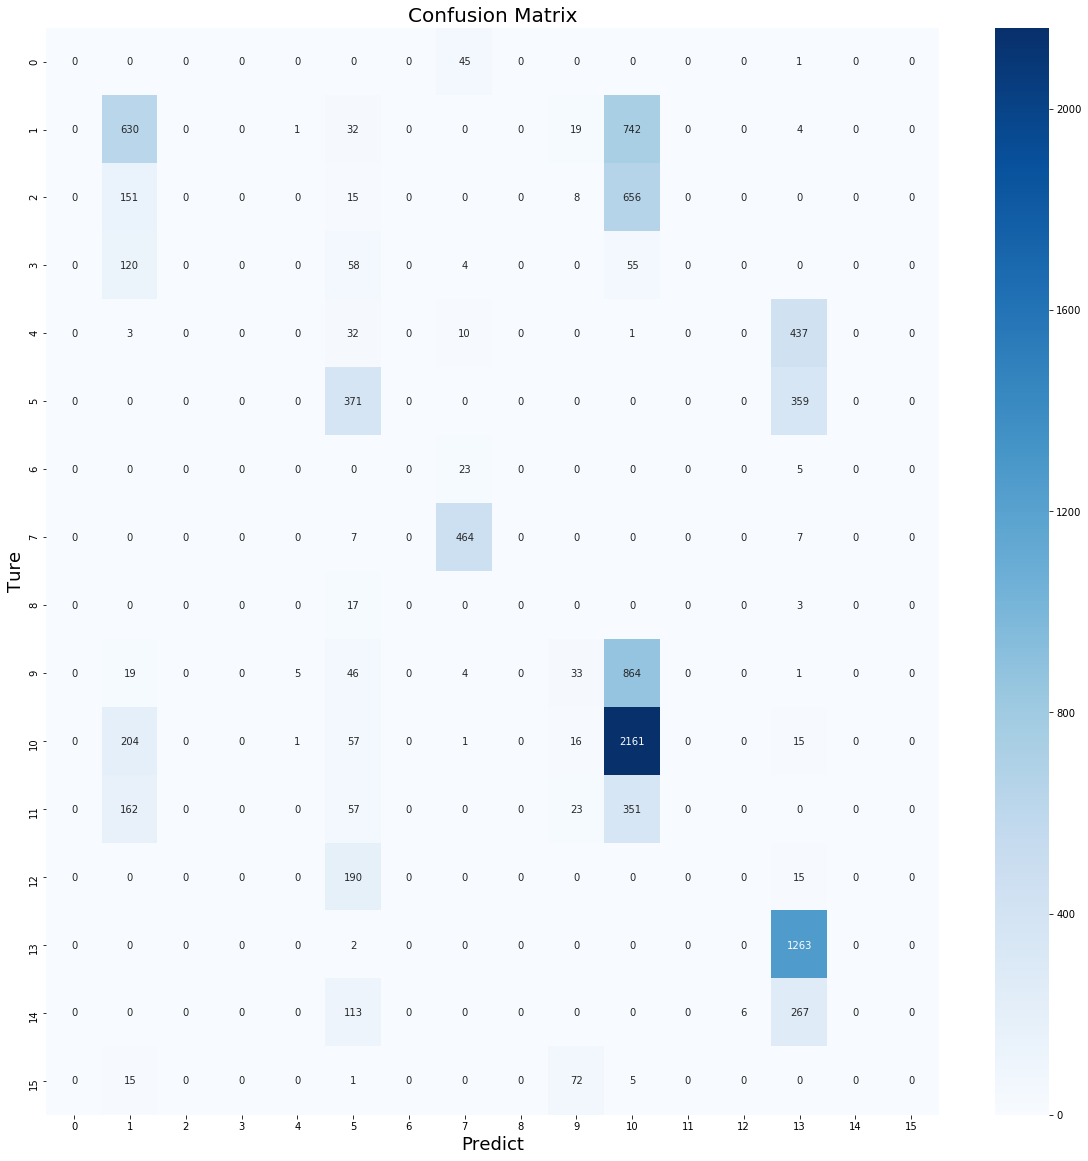

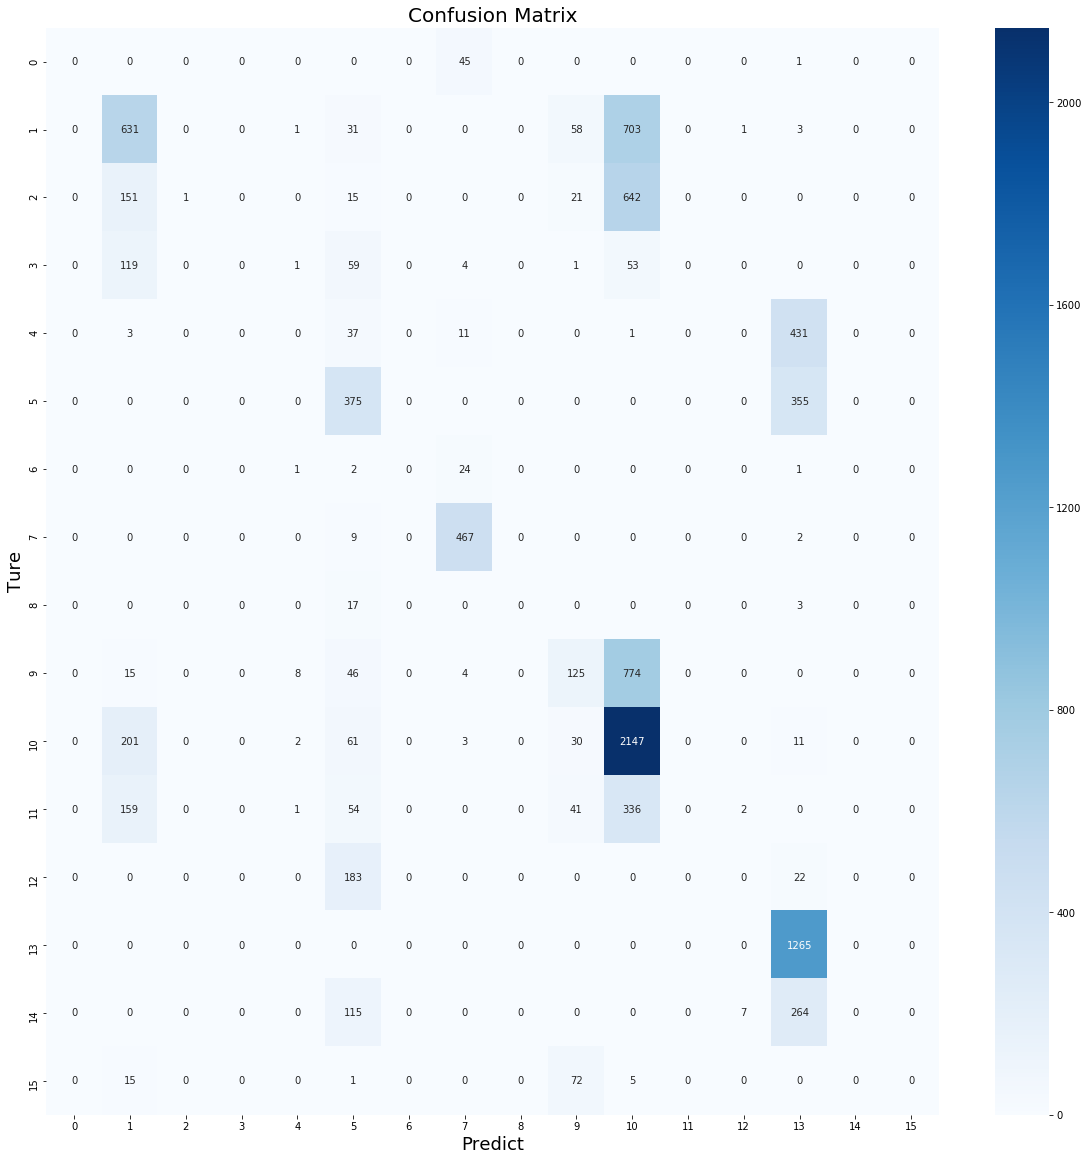

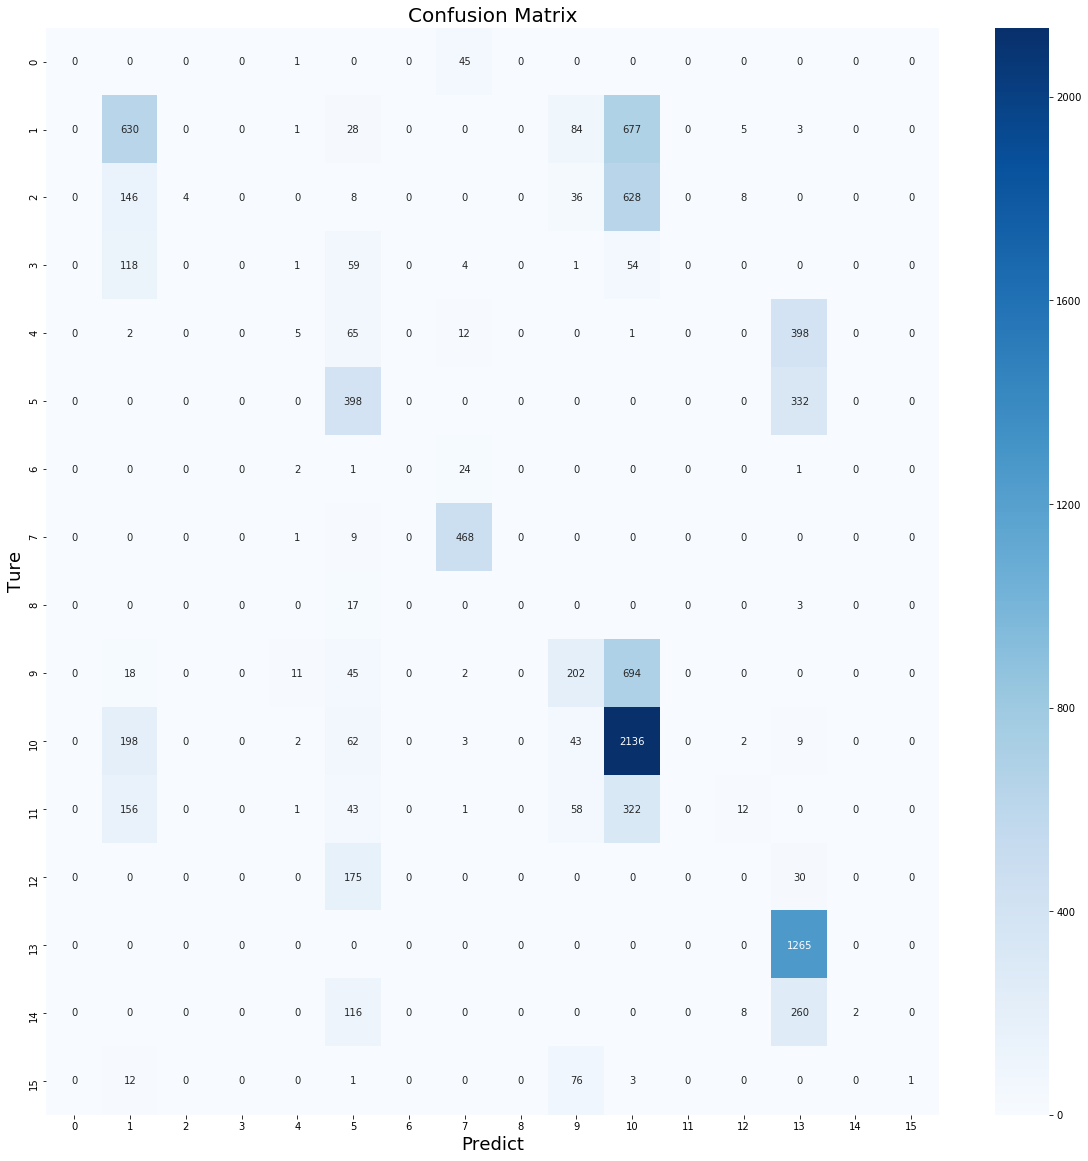

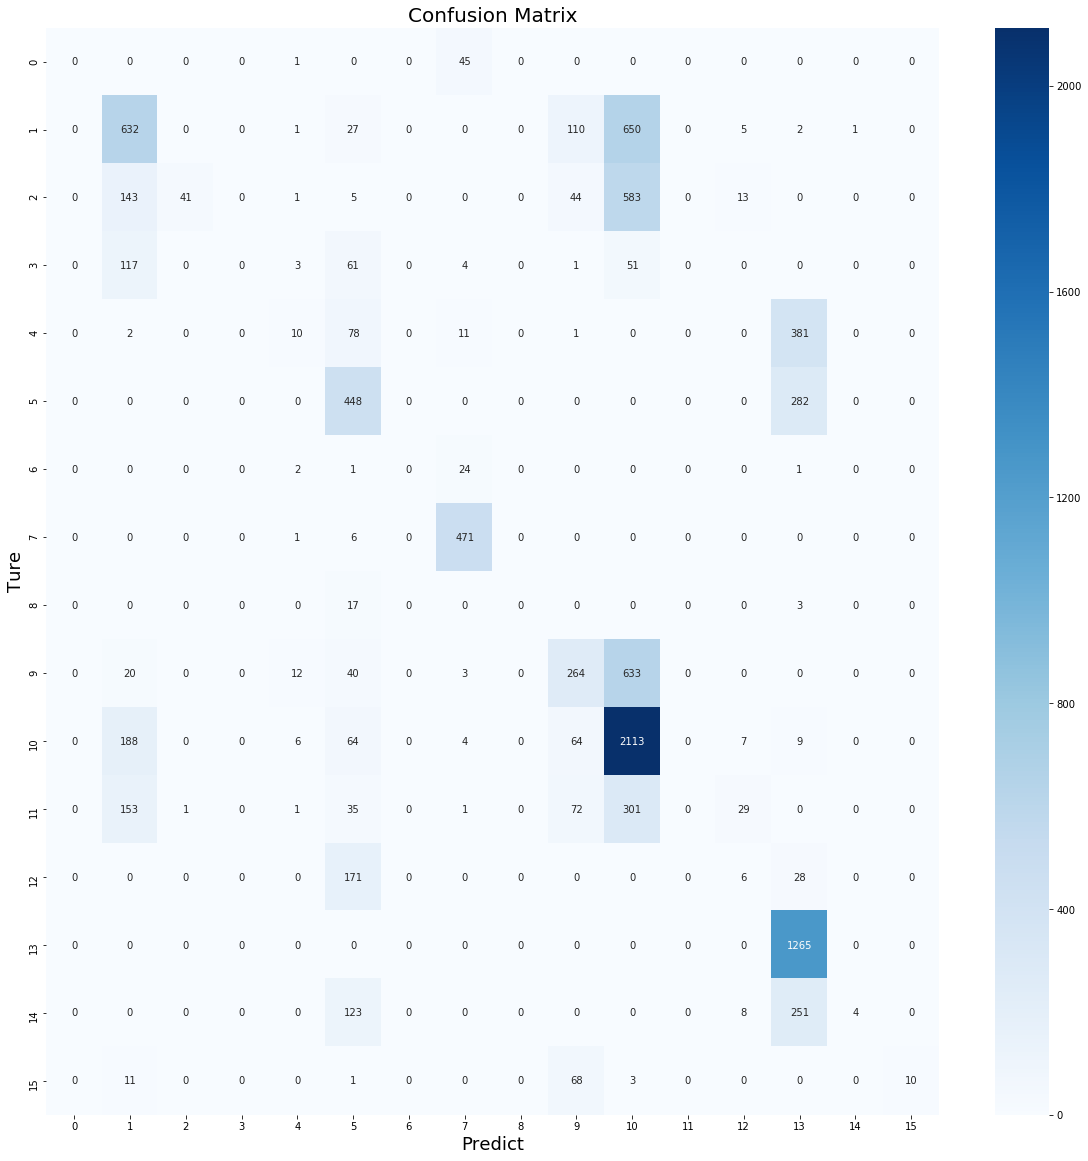

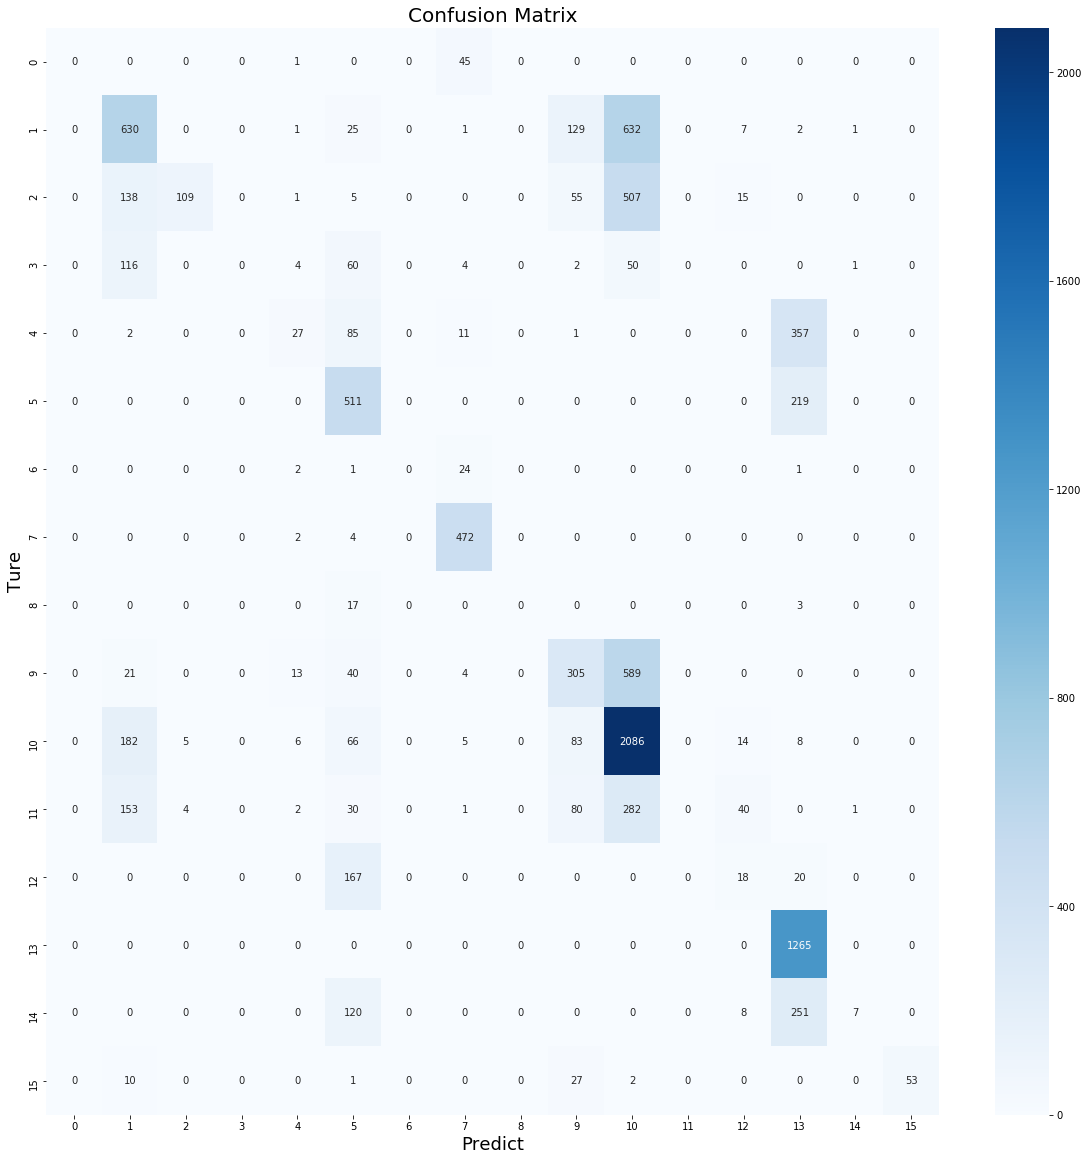

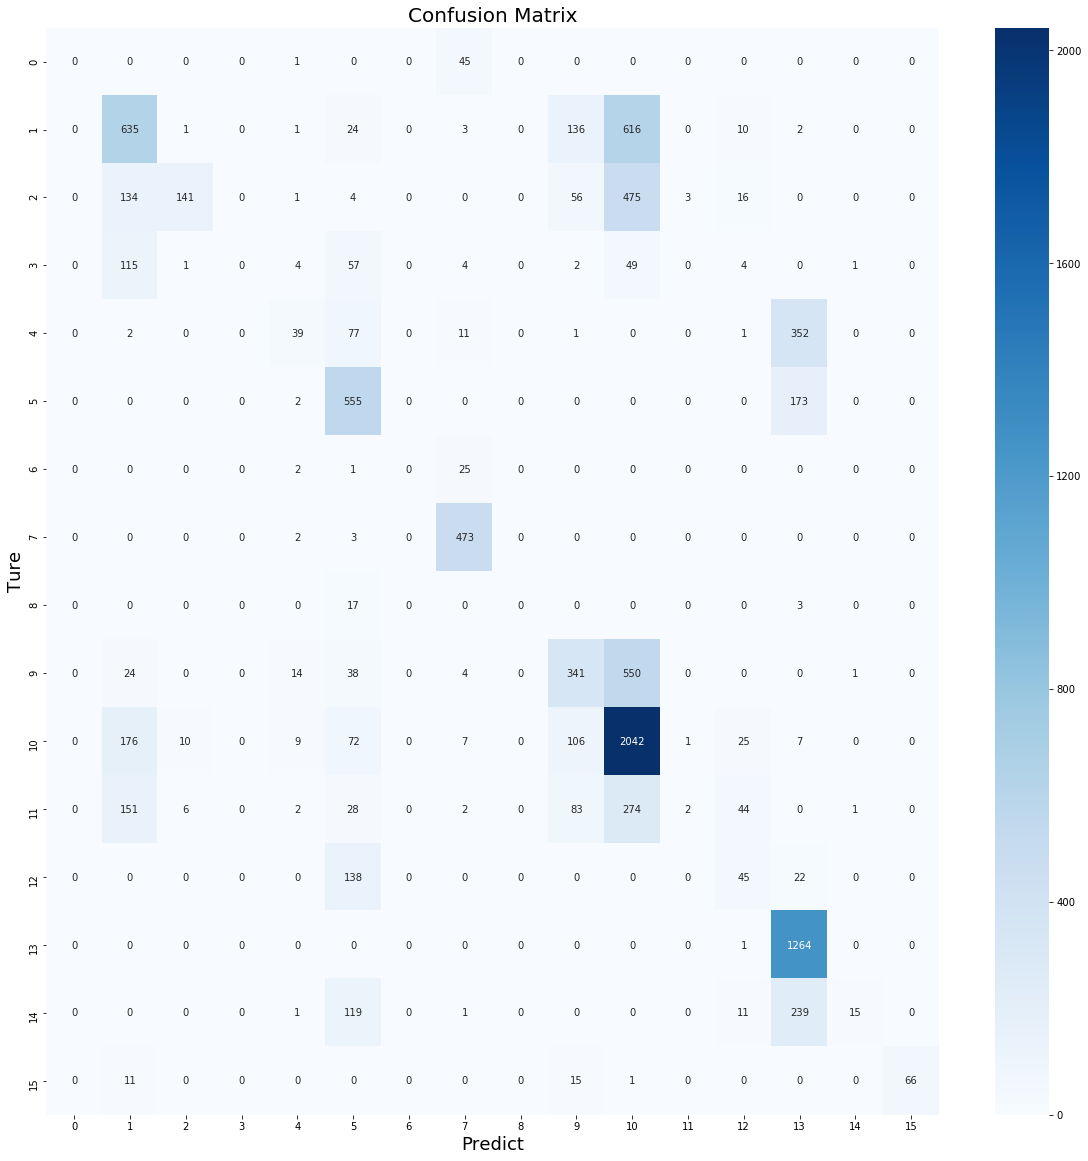

In [34]:
for i in range(26):
    """
        26是惩罚系数的个数
    """
    plot_cm(generate_confusion_matrix(X,i,Y))

## 对不同惩罚系数下的系数矩阵的分类结果进行评价
***
评价指标
- Over all Accuracy
- Kappa系数
#### kappa系数的评价
---
- kappa=1 两次判断完全一致
- kappa>=0.75 比较满意的一致程度
- kappa<0.4 不够理想的一致程度
---
最终结果使用一个列表-字典存储

In [35]:
from sklearn.metrics import cohen_kappa_score,accuracy_score #计算kappa系数和over all accuracy

metric_list = []#存储评价指标的空列表

for i in range(26):
    predict_matrix = generate_prediction_matrix_for_all(X,i=i)
    predict_vec = np.argmax(predict_matrix,axis=1)#生成一个列向量，该列向量元素为矩阵的每行最大值的下标
    truth_vec = np.argmax(Y,axis=1)#真值向量
    acc = accuracy_score(truth_vec,predict_vec, normalize=True, sample_weight=None)#计算oa
    kappa = cohen_kappa_score(truth_vec,predict_vec,labels=labels)#计算Kappa系数
    #print(f'第{i}个惩罚系数下的正确率为{acc}，kappa系数为{kappa}，该惩罚系数使用了{len(band_selected[i])}个波段')
    dic = {'band_num':len(band_selected[i]),'oa':acc,'kappa':kappa,'band':band_selected[i]}
    #该字典包含'band_num':选择出的波段个数，‘oa’：分类准确率，‘kappa’：kappa系数，‘band’：选中的波段标号集合
    metric_list.append(dic)

In [36]:
metric_list

[{'band_num': 0, 'oa': 0.23953556444531174, 'kappa': 0.0, 'band': set()},
 {'band_num': 2, 'oa': 0.23953556444531174, 'kappa': 0.0, 'band': {148, 149}},
 {'band_num': 2,
  'oa': 0.36218167626109865,
  'kappa': 0.1919267567321975,
  'band': {148, 149}},
 {'band_num': 2,
  'oa': 0.3618889647770514,
  'kappa': 0.19667522567377105,
  'band': {148, 149}},
 {'band_num': 2,
  'oa': 0.36101083032490977,
  'kappa': 0.19709271888887592,
  'band': {148, 149}},
 {'band_num': 2,
  'oa': 0.36052297785149773,
  'kappa': 0.19799810748796864,
  'band': {148, 149}},
 {'band_num': 3,
  'oa': 0.3602302663674505,
  'kappa': 0.19912164087298145,
  'band': {74, 148, 149}},
 {'band_num': 3,
  'oa': 0.3601326958727681,
  'kappa': 0.20098249292678738,
  'band': {74, 148, 149}},
 {'band_num': 6,
  'oa': 0.3600351253780857,
  'kappa': 0.2020910086785871,
  'band': {74, 148, 149, 166, 170, 172}},
 {'band_num': 5,
  'oa': 0.3602302663674505,
  'kappa': 0.2028747525867457,
  'band': {74, 148, 149, 166, 172}},
 {'ban

### 绘制被选择波段数目与正确率(OA)和Kappa系数之间的关系图

In [39]:
band_num = []#波段个数的列表
oa = []#正确率列表
kappa = []#kappa列表
for i in range(26):
    band_num.append(metric_list[i]['band_num'])
    oa.append(metric_list[i]['oa'])
    kappa.append(metric_list[i]['kappa'])

#### 波段数目---OA关系图

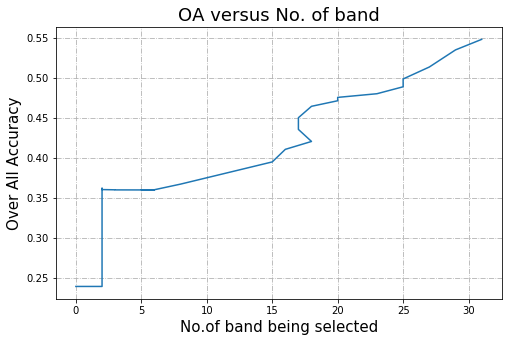

In [40]:
#绘图
plt.figure(figsize=(8,5))
plt.xlabel('No.of band being selected',fontsize=15)
plt.ylabel('Over All Accuracy',fontsize=15)
plt.title('OA versus No. of band',fontsize = 18,weight = 'normal')
plt.plot(band_num,oa)
plt.grid(linestyle='-.')
plt.show()

#### 波段数目---Kappa系数关系图

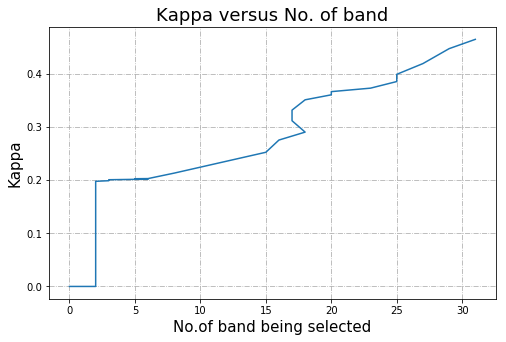

In [41]:
#绘图
plt.figure(figsize=(8,5))
plt.xlabel('No.of band being selected',fontsize=15)
plt.ylabel('Kappa',fontsize=15)
plt.title('Kappa versus No. of band',fontsize = 18,weight = 'normal')
plt.plot(band_num,kappa)
plt.grid(linestyle='-.')
plt.show()

## 波段数目为30~50之间的混淆矩阵和准确率、kappa系数

In [ ]:
i = 0#记录下标的计数器
index = []#记录挑选出的波段集合对应下标，用来绘制混淆矩阵
chosen_list = []#记录选取处的字典的列表
for dic in metric_list:
    """
        从metric_list中挑选出波段数目介于30~50的字典,以此来获取准确率和Kappa系数
    """
    if dic['band_num'] >= 30 and dic['band_num'] <= 50:
        chosen_list.append(dic)
        index.append(i)#记录该下标
        i += 1
    else:
        i += 1

In [ ]:
chosen_list

In [ ]:
for _index_ in index:
    #绘制混淆矩阵
    plot_cm(generate_confusion_matrix(X,_index_,Y))

## 波段数目在50~100之间的混淆矩阵和准确率及kappa系数

In [ ]:
i = 0#记录下标的计数器
index1 = []#记录挑选出的波段对应下标，用来绘制混淆矩阵
chosen_list1 = []#记录选取处的字典的列表
for dic in metric_list:
    """
        从metric_list中挑选出波段数目介于30~50的字典,以此来获取准确率和Kappa系数
    """
    if dic['band_num'] >= 50 and dic['band_num'] <= 100:
        chosen_list1.append(dic)
        index1.append(i)#记录该下标
        i += 1
    else:
        i += 1

In [ ]:
chosen_list1

In [ ]:
for _index_ in index1:
    #绘制混淆矩阵
    plot_cm(generate_confusion_matrix(X,_index_,Y))